# Explain what we are doing

1. Create Grpah

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch
from torch_geometric.data import Data
import torchsde
from torch import nn
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
from torchdiffeq import odeint
import json
from bayesian_gcn import BayesianGCNConv

# Set the random seed for all devices (CPU and CUDA)
seed = 41
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Set Numpy the random seed
np.random.seed(seed)


In [2]:
class PoliticalCompassGraph:
    def __init__(self, num_nodes, classes, colors, cluster_std=1.0, center_box=(-2.0, 2.0), proximity_threshold=3.0, same_class_connection_prob=0.05, different_class_connection_prob=0.01, connection_randomness_factor=0.0, same_class_proximity_weight=0.15, different_class_proximity_weight=0.05):
        self.num_nodes = num_nodes
        self.classes = classes
        self.colors = colors
        self.cluster_std = cluster_std
        self.center_box = center_box
        self.proximity_threshold = proximity_threshold
        self.same_class_connection_prob = same_class_connection_prob
        self.different_class_connection_prob = different_class_connection_prob
        self.connection_randomness_factor = connection_randomness_factor
        self.same_class_proximity_weight = same_class_proximity_weight
        self.different_class_proximity_weight = different_class_proximity_weight
        self.G = nx.Graph()
        self.features, self.labels = self.generate_features()
        self.centers = self.calculate_centers()
        self.node_colors, self.node_sizes = self.assign_node_properties()
        self.add_edges()

    def generate_features(self):
        return make_blobs(n_samples=self.num_nodes, centers=len(self.classes), random_state=42, 
                          cluster_std=self.cluster_std, center_box=self.center_box)

    def calculate_centers(self):
        return [self.features[self.labels == i].mean(axis=0) for i in range(len(self.classes))]

    def assign_node_properties(self):
        node_colors = [self.colors[self.classes[label]] for label in self.labels]
        node_sizes = [500] * self.num_nodes  # All sizes are 500 for visualization
        return node_colors, node_sizes

    def add_edges(self):
        self.G.add_nodes_from(range(self.num_nodes))
        for i in range(self.num_nodes):
            for j in range(i+1, self.num_nodes):
                dist = np.linalg.norm(self.features[i] - self.features[j])
                proximity_factor = max((self.proximity_threshold - dist) / self.proximity_threshold, 0)
                same_class_proximity_weight =  self.same_class_proximity_weight*proximity_factor 
                different_class_proximity_weight =  self.different_class_proximity_weight*proximity_factor
                
                same_class_connection_likelihood  = same_class_proximity_weight + self.same_class_connection_prob + self.connection_randomness_factor
                different_class_connection_likelihood  = different_class_proximity_weight + self.different_class_connection_prob + self.connection_randomness_factor
                
                if self.labels[i] == self.labels[j] and np.random.rand() < same_class_connection_likelihood:
                    self.G.add_edge(i, j)
                elif self.labels[i] != self.labels[j] and np.random.rand() < different_class_connection_likelihood:
                    self.G.add_edge(i, j)
                    
    def get_graph(self):
            """Returns the graph object."""
            return self.G

    def get_features(self):
        """Returns the features of the nodes."""
        return self.features

    def get_labels(self):
        """Returns the labels of the nodes."""
        return self.labels

    def draw_graph(self):
        plt.figure(figsize=(8, 6))
        nx.draw(self.G, node_color=self.node_colors, node_size=self.node_sizes, with_labels=True)
        plt.show()  

    def plot_political_compass(self):
        plt.figure(figsize=(8, 6))
        plt.scatter(self.features[:, 0], self.features[:, 1], c=[self.colors[self.classes[label]] for label in self.labels], s=100)

        plt.title('Voters Political Compass', fontsize=30, y=1.15)
        plt.tight_layout()
        plt.tick_params(axis='both', which='major', labelsize=18)  # Adjust the fontsize as needed
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        
        # Customize the y-axis tick labels
        plt.yticks([-4, -0.5, 0, 0.5, 4], ['', '', '0', '', ''], fontsize=26)

        # Customize the x-axis tick labels
        plt.xticks([-4, -0.5, 0, 0.5, 4], ['', '', '0', '', ''], fontsize=26)
        
        # Add custom text labels outside the axis
        plt.text(4.1, 0, 'Right', fontsize=26, ha='left', va='center')
        plt.text(-4.5, 0, 'Left', fontsize=26, ha='right', va='center')
        plt.text(0, 4.1, 'Liberal', fontsize=26, ha='center', va='bottom')
        plt.text(0, -4.7, 'Authoritarian', fontsize=26, ha='center', va='top')
        # Add arrows to the x-axis and y-axis
        plt.arrow(-5, 0, 8.8, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')
        plt.arrow(5, 0, -8.8, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')
        plt.arrow(0, -4.7, 0, 8.45, head_width=0.2, head_length=0.2, fc='black', ec='black')
        plt.arrow(0, 4.7, 0, -8.45, head_width=0.2, head_length=0.2, fc='black', ec='black')

        plt.show()

In [3]:
import torch

# Check if CUDA (GPU support) is available in PyTorch
cuda_available = torch.cuda.is_available()

# Print whether CUDA is available
print(f"CUDA Available: {cuda_available}")

# If CUDA is available, print the number of GPUs and their names
if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA-compatible GPUs detected.")


CUDA Available: True
Number of GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080 Ti
GPU 1: NVIDIA GeForce RTX 2080 Ti


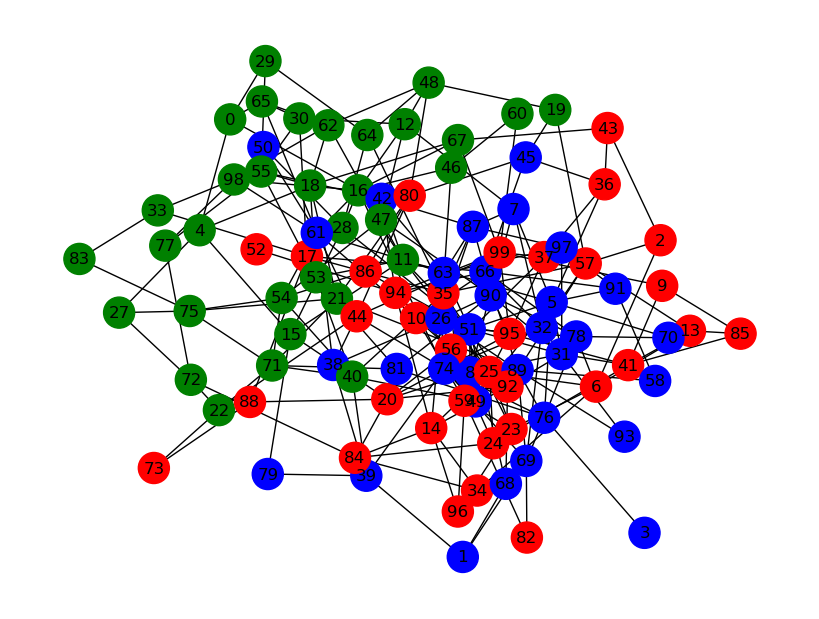

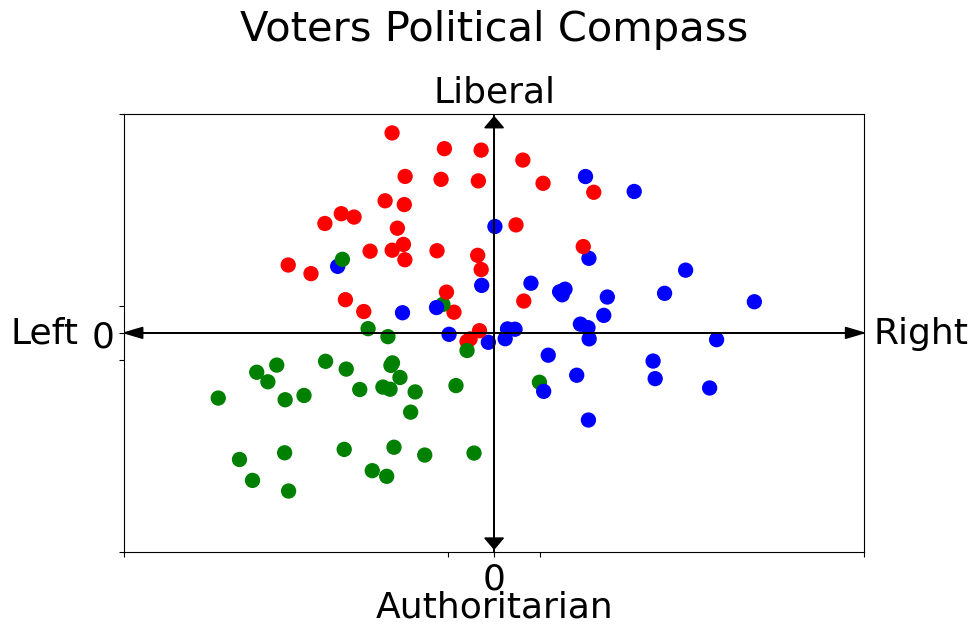

In [4]:
classes = ['Red', 'Blue', 'Green']
colors = {'Red': 'red', 'Blue': 'blue', 'Green': 'green'}
num_nodes=100
political_compass_graph = PoliticalCompassGraph(num_nodes=num_nodes, classes=classes, colors=colors)
political_compass_graph.draw_graph()
political_compass_graph.plot_political_compass()



In [5]:
G, features, labels = political_compass_graph.get_graph(), political_compass_graph.get_features(), political_compass_graph.get_labels()

In [6]:
def split_data(num_nodes, train_percent=0.8):
    num_train_nodes = int(num_nodes * train_percent)  
    train_mask = [i < num_train_nodes for i in range(num_nodes)]
    test_mask = [i >= num_train_nodes for i in range(num_nodes)]
    return train_mask, test_mask


def convert_to_torch_geometric(G, features, labels, train_mask, test_mask):
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    train_mask = torch.tensor(train_mask)
    test_mask = torch.tensor(test_mask)
    return Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)


def convert_to_torch_geometric(G, features, labels, train_mask, test_mask):
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    train_mask = torch.tensor(train_mask)
    test_mask = torch.tensor(test_mask)
    return Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask).to(device)



In [7]:
# Assuming political_compass_graph is an instance of PoliticalCompassGraph
G, features, labels = political_compass_graph.get_graph(), political_compass_graph.get_features(), political_compass_graph.get_labels()

# Split the data
train_mask, test_mask = split_data(len(labels), train_percent=0.8)  # Change train_percent as needed

# Convert to PyTorch Geometric format
data = convert_to_torch_geometric(G, features, labels, train_mask, test_mask)

# Calculate the number of unique classes
num_classes = len(np.unique(labels))


## Models 

THe model Graph Neural ODEs and Graph Neural SDEs use the convolutial laters as the the graph 

In [8]:

class MyGCN(torch.nn.Module):
    def __init__(self, edge_index, in_feats, out_feats, activation=None, dropout=0):
        super(MyGCN, self).__init__()
        self.edge_index = edge_index
        self.dropout = dropout
        self.activation = activation
        self.conv1 = GCNConv(in_feats, out_feats)

    def forward(self, x):
        x = self.conv1(x, self.edge_index)
        if self.activation is not None:
            x = self.activation(x)
        x = F.dropout(x, p=self.dropout)
        return x




In [9]:
class GraphNeuralODE(torch.nn.Module):
    def __init__(self, ode_func, in_net=None, out_net=None, method='rk4', atol=1e-3, rtol=1e-4):
        super(GraphNeuralODE, self).__init__()
        self.in_net = in_net
        self.projection_net = out_net

        self.ode_func = ode_func
        self.method = method
        
        self.atol = atol
        self.rtol = rtol

    def f(self, t, y):
        return self.ode_func(y)

    def forward(self, data):
        x = data.x
        x = self.in_net(x).to(device)
        t = torch.tensor([0, 1]).float().to(device)  # Define the time steps
        t_span = torch.linspace(t[0], t[1], steps=5)  # Adjust the number of steps as needed
        x = odeint(self.f, x.to(device), t_span.to(device) , method=self.method, atol=self.atol, rtol=self.rtol)
        ode_output_time_1 = x[-1].to(device)
        x = self.projection_net(ode_output_time_1)
        return x



Now we can initialize the Graph Neural ODE as follows

In [10]:
n_dimension = 16
num_feats = features.shape[1]
gcn_in = MyGCN(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimension, activation=nn.Softplus(), dropout=0.0).to(device) 

gde_func = nn.Sequential(MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=n_dimension, activation=nn.Softplus(), dropout=0.0),
                  MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=n_dimension, activation=None, dropout=0.0)
                 ).to(device)

# Complete gcn_out
gcn_out = MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=num_classes, activation=nn.Softmax(), dropout=0.).to(device)

neural_ode = GraphNeuralODE(in_net=gcn_in, ode_func=gde_func, out_net=gcn_out).to(device)

However, we would have to run all of this lines of code to initalize the Neural ODE, so insted we use the following Graph Neural ODE initializer

In [11]:
# we wrap all of this Neural ODE initializer
def initialize_graph_neural_ode(data, device=device, gde_func=gde_func, num_classes=num_classes):
    num_feats = data.x.shape[1]

    # Initialize GCN layers
    gcn_in = MyGCN(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimension, activation=nn.Softplus(), dropout=0.0).to(device) 
    
    # Define and initialize ODE function
    gde_func = nn.Sequential(MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=n_dimension, activation=nn.Softplus(), dropout=0.0),
                  MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=n_dimension, activation=None, dropout=0.0)
                 ).to(device)

    # Output Layer
    gcn_out = MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=num_classes, activation=nn.Softmax(), dropout=0.).to(device)
    
    # Initialize Neural ODE
    neural_ode = GraphNeuralODE(in_net=gcn_in, ode_func=gde_func, out_net=gcn_out).to(device)

    return neural_ode

# Usage example
neural_ode = initialize_graph_neural_ode(data)


In [12]:
from torch import distributions
import math
def _stable_division(a, b, epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b

class LatentGraphNeuralSDE(torchsde.SDEStratonovich):

    def __init__(self, theta=1.0, mu=0., sigma=1., in_net=None, drift_net=None, out_net=None):
        super(LatentGraphNeuralSDE, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))

        sde_output_dimension = n_dimension
        # Prior drift. Prioir "dimymics"
        self.register_buffer("theta", torch.full((1, sde_output_dimension), theta))
        self.register_buffer("mu", torch.full((1, sde_output_dimension), mu))
        self.register_buffer("sigma", torch.full((1, sde_output_dimension), sigma))

        # p(y0).
        self.register_buffer("py0_mean", torch.full((1, sde_output_dimension), mu))
        self.register_buffer("py0_logvar", torch.full((1, sde_output_dimension), logvar))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = drift_net

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.full((1, sde_output_dimension), mu), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.full((1, sde_output_dimension), logvar), requires_grad=True)
        
        self.in_net = in_net
        self.projection_net=out_net
        
    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            t = torch.full_like(y, fill_value=t)
        # Positional encoding in transformers for time-inhomogeneous posterior.
        return self.net(y)

    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)

    def h(self, t, y):  # Prior drift.
        prioir_drift = self.theta * (self.mu - y)
        return prioir_drift

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:n_dimension]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:n_dimension]
        g = self.g(t, y)
        g_logqp = torch.zeros(y.shape[0], 1).to(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, data, eps=None):
        ts = data.x.to(device)
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  

        y0 = self.in_net(ts).to(device)
        aug_y0 = torch.cat([y0, torch.zeros(y0.shape[0], 1).to(ts)], dim=1)
        ts_vis = torch.tensor([0, 0.01]).float().to(device)
        vis_batch_size = num_nodes
        print('vis_batch_size', vis_batch_size)
        bm = torchsde.BrownianInterval(
            t0=ts_vis[0],
            t1=ts_vis[-1],
            size=(vis_batch_size, aug_y0.shape[1]),
            device=device,
            levy_area_approximation='space-time'
        )  # We need space-time Levy area to use the SRK solver
        print('bm.size', bm.size)
        aug_ys = torchsde.sdeint(
            sde=self,
            y0=aug_y0,
            ts=torch.tensor([0, 0.001]).float().to(device),
            method='midpoint',
            bm=bm,
            rtol= 1e-3,
            atol= 1e-3,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:n_dimension], aug_ys[-1, :, n_dimension]
        ys = self.projection_net(ys[-1])
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)


Initialize Graph Neural SDE

In [15]:
from gn_sde import LatentGraphSDE

num_feats = features.shape[1]
gcn_in = MyGCN(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimension, activation=nn.Softplus(), dropout=0.0).to(device) 

gnn_f = nn.Sequential(
    MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=n_dimension, activation=nn.Softplus(), dropout=0.0),
    MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=n_dimension, activation=None, dropout=0.0)
).to(device)

# Complete gcn_out
gcn_out = nn.Sequential(
  MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=num_classes, activation=nn.Softmax(), dropout=0.).to(device)
).to(device)

model_latentSDE = LatentGraphSDE(drift_net=gnn_f, in_net=gcn_in, out_net=gcn_out, device=device).to(device)

Better code:

In [17]:
def initialize_graph_neural_sde(data, device=device, n_dimension=n_dimension, num_classes=num_classes):

    num_feats = features.shape[1]
    gcn_in = MyGCN(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimension, activation=nn.Softplus(), dropout=0.0).to(device) 

    gnn_f = nn.Sequential(
        MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=n_dimension, activation=nn.Softplus(), dropout=0.0),
        MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=n_dimension, activation=None, dropout=0.0)
    ).to(device)

    # Complete gcn_out
    gcn_out = nn.Sequential(
    MyGCN(edge_index=data.edge_index, in_feats=n_dimension, out_feats=num_classes, activation=nn.Softmax(), dropout=0.).to(device)
    ).to(device)


    # Initialize the Graph Neural SDE model
    graph_neural_sde = LatentGraphSDE(drift_net=gnn_f, in_net=gcn_in, out_net=gcn_out, sde_output_dim=n_dimension, device=device).to(device)

    return graph_neural_sde

# Usage example
graph_neural_sde = initialize_graph_neural_sde(data)


Graph CNN

In [18]:


class MyGCN2(torch.nn.Module):
    def __init__(self, edge_index, in_feats=num_feats, out_feats=num_classes, activation=None, dropout=0):
        super(MyGCN2, self).__init__()
        self.edge_index = edge_index
        self.dropout = dropout
        self.activation = activation
        self.conv1 = GCNConv(in_feats, 16)
        self.conv2 = GCNConv(16, 16)
        # self.conv3 = GCNConv(16, 16)
        self.conv4 = GCNConv(16, out_feats)

    def forward(self, data):
        x = data.x
        x = self.conv1(x, self.edge_index)
        if self.activation is not None:
            x = self.activation(x)
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, self.edge_index)
        x = self.activation(x)
        # x = self.conv3(x, self.edge_index)
        # x = self.activation(x)
        x = self.conv4(x, self.edge_index)
        x = self.activation(x)
        return F.softmax(x, dim=1)
    
    
gcn_model = MyGCN2(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimension, activation=F.softplus, dropout=0.0).to(device)
    

In [19]:
def initialize_gcn_model(data, device=device, num_feats=num_feats, n_dimension=n_dimension, dropout=0.0):
    model = MyGCN2(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimension, activation=F.softplus, dropout=dropout).to(device)
    return model

gcn_model = initialize_gcn_model(data)

In [20]:
gcn_model(data)

tensor([[0.0402, 0.0990, 0.0381,  ..., 0.0427, 0.0868, 0.0487],
        [0.0599, 0.0587, 0.0410,  ..., 0.0589, 0.0713, 0.0487],
        [0.0559, 0.0724, 0.0417,  ..., 0.0571, 0.0801, 0.0505],
        ...,
        [0.0517, 0.0622, 0.0377,  ..., 0.0512, 0.0768, 0.0489],
        [0.0412, 0.0897, 0.0355,  ..., 0.0426, 0.0880, 0.0473],
        [0.0393, 0.0847, 0.0300,  ..., 0.0403, 0.0927, 0.0407]],
       device='cuda:1', grad_fn=<SoftmaxBackward0>)

### Ensemble of gcn

In [21]:
# Step 1: Train individual models
number_of_ensemble = 5
gcn_models = [initialize_gcn_model(data) for _ in range(number_of_ensemble)]

### Bayesian GCN

In [22]:

class BayesianGCN(torch.nn.Module):
    def __init__(self, edge_index, in_feats=num_feats, out_feats=num_classes, activation=None, dropout=0):
        super(BayesianGCN, self).__init__()
        """
        Create a Bayesian Graph Convolutional Network with two layers.
        
        Parameters:
            g: Graph structure (e.g., from DGL or PyTorch Geometric)
            num_features: Number of input features
            hidden_units: Number of units in the hidden layer
            num_classes: Number of output classes (or units in the output layer)
        """
        self.edge_index = edge_index
        self.dropout = dropout
        self.activation = activation
        self.bayes_conv1 = BayesianGCNConv(in_feats, 16, prior_mean = 0.0, prior_variance = 1.0) 
        self.bayes_conv2 = BayesianGCNConv(16, out_feats, prior_mean = 0.0, prior_variance = 1.0)

    def forward(self, data, return_kl=True):
        x = data.x
        x, kl1 = self.bayes_conv1(x, self.edge_index, return_kl=return_kl)
        if self.activation is not None:
            x = self.activation(x)
        x = F.dropout(x, p=self.dropout)
        x, kl2 = self.bayes_conv2(x, self.edge_index, return_kl=return_kl)
        
        if return_kl:
            total_kl = kl1 + kl2
            return F.softmax(x, dim=1), total_kl
        return F.softmax(x, dim=1)    
        

In [23]:
def initialize_bayesian_gcn_model(data, device=device, num_feats=num_feats, n_dimension=n_dimension, dropout=0.0):
    model = BayesianGCN(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimension, activation=F.softplus, dropout=dropout).to(device)
    return model

bayes_gcn_model = initialize_bayesian_gcn_model(data)

In [24]:
### Delete me

import matplotlib.pyplot as plt
import torch

def train(model, data, optimizer, epochs):
    model.train()
    means, variances = [], []

    for epoch in range(epochs):
        optimizer.zero_grad()
        out, kl_divergence = model(data, return_kl=True)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) + kl_divergence

        loss.backward()
        optimizer.step()

        # Capture the mean and variance
        mu = model.bayes_conv1.mu_weight.detach().cpu().numpy()
        rho = model.bayes_conv2.rho_weight.detach().cpu().numpy()
        means.append(mu)
        variances.append(rho)

    return means, variances


In [25]:
def plot_distributions(epoch, mean, variance, save_path):
    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Epoch {epoch}')
    
    plt.subplot(1, 2, 1)
    plt.hist(mean.flatten(), bins=30, alpha=0.7, color='blue')
    plt.title('Weight Mean Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(variance.flatten(), bins=30, alpha=0.7, color='red')
    plt.title('Weight Variance Distribution')

    plt.savefig(f'{save_path}/epoch_{epoch}.png')
    plt.close()


### Include GAT, Bayesian GNN, Ensemble GNN, (Others?)

## Train Functions

In [33]:
# for Deterministic models GCN, GN-ODE
def train(model, data, optimizer, loss_func, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_func(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = F.nll_loss(out[mask], data.y[mask])
        _, pred = out.max(dim=1)
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
    return loss.item(), acc


def entropy_fn(prediction_probabilities):
    eps = 1e-9
    p_clipped = torch.clamp(prediction_probabilities, eps, 1 - eps)
    entropy = -(p_clipped * torch.log(p_clipped)).sum(dim=1)
    return entropy
        

def train_and_evaluate(model, data, learning_rate=0.01, weight_decay=5e-4, num_epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        _ = train(model, data, optimizer, F.nll_loss, data.train_mask)
        train_loss, train_acc = evaluate(model, data, data.train_mask)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    test_loss, test_acc = evaluate(model, data, data.test_mask)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return model, test_acc


def accuracy_with_entropy_threshold(prediction_probabilities, entropy, labels, entropy_threshold, mask_data):
    # Only predictions if the entropy is less than the given threshold
    
    predictions_probabilities = prediction_probabilities[mask_data]
    labels = labels[mask_data]
    entropy = entropy_fn(prediction_probabilities)
    entropy = entropy[mask_data]
    mask = (entropy <= entropy_threshold) # True if the entropy of the prediction is less or equal to the threshold
    predictions_bellow_entropy = predictions_probabilities[mask].to('cpu')
    labels = labels[mask].to('cpu') 
    _, pred = predictions_bellow_entropy.max(dim=1)
    correct = float(pred.eq(labels).sum().item())
    num_of_predictions = labels.size(0)
    if num_of_predictions > 0:
        acc = correct / num_of_predictions
    else:
        acc = None  # to avoid division by zero
    return acc, num_of_predictions


def evaluate_with_entropy_threshold(model, data, entropy_threshold=0):
    model.eval()
    with torch.no_grad():
        prediction = model(data)
        entropy = entropy_fn(prediction)
        acc, num_of_predictions = accuracy_with_entropy_threshold(prediction, entropy, data.y, entropy_threshold=entropy_threshold, mask_data=data.test_mask)
    return acc, num_of_predictions




# for Stochastic Models (BNN, GN-SDE)
def train_with_kl(model, data, optimizer, kl_scheduler):
    optimizer.zero_grad()
    out, kl_div = model(data.x)
    ce_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    total_loss = ce_loss + kl_div*kl_scheduler.val
    total_loss.backward()
    optimizer.step()
    kl_scheduler.step()
    return model, total_loss.item()


def mc_sample_stats(model, data, n_samples=100):
    """
    Computes variance, mean probabilities, and mean entropy of Monte Carlo samples.
    
    Args:
    model: BNN model used for generating predictions.
    data: Input data for predictions.
    n_samples: Number of Monte Carlo samples to draw.
    
    Returns:
    var: Variance of the samples.
    mean: Mean probabilities of the samples.
    mean_entropy: Mean entropy of the samples.
    """
    samples = []
    samples_entropy = []
    for _ in range(n_samples):
        output_probability, _ = model(data.x)
        sample = output_probability
        samples.append(sample)
        sample_entropy = entropy_fn(sample)
        samples_entropy.append(sample_entropy)
    
    samples_tensor = torch.stack(samples) # to keep it consistant we keep the samples mean and var as torch tensors.
    var = torch.var(samples_tensor, dim=0, unbiased=True).sum(dim=1)  # Sum across features for each sample
    mean = torch.mean(samples_tensor, dim=0)
    mean_entropy = torch.mean(samples_tensor, dim=0)
    
    return var, mean, mean_entropy
    
    
def evaluate_stochastic_model(model, data, mask_data, n_samples=100, entropy_threshold=np.inf):
    model.eval()
    with torch.no_grad():
        _, samples_mean, samples_entropy = mc_sample_stats(model, data, n_samples=n_samples)
        acc, num_of_predictions = accuracy_with_entropy_threshold(samples_mean, samples_entropy, data.y, entropy_threshold=entropy_threshold, mask_data=mask_data)
    return acc, num_of_predictions


class LinearScheduler(object):
    def __init__(self, iters, maxval=1.00):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


def kl_train_and_evaluate(model, data, learning_rate=0.01, weight_decay=5e-4, num_epochs=100):
    kl_scheduler = LinearScheduler(iters=50)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for _ in range(num_epochs):
        model, _ = train_with_kl(model, data, optimizer, kl_scheduler)
        train_accuracy, num_of_predictions = evaluate_stochastic_model(model, data, mask_data=data.train_mask, n_samples=1, entropy_threshold=np.inf)
    print(f'Train Accuracy: {train_accuracy:.4f}, Number of Predictions: {num_of_predictions}')
    
    test_accuracy, num_of_predictions  = evaluate_stochastic_model(model, data,  mask_data=data.test_mask, n_samples=100, entropy_threshold=np.inf)
    print(f'Test Accuracy: {test_accuracy:.4f}, Number of Predictions: {num_of_predictions}')
    return model, test_accuracy


# For esemble models:
def entropy_fn(prediction_probabilities):
    eps = 1e-9
    p_clipped = torch.clamp(prediction_probabilities, eps, 1 - eps)
    entropy = -(p_clipped * torch.log(p_clipped)).sum(dim=1)
    return entropy

def ensemble_inference(models, data, entropy_threshold=np.inf):
    predictions = []
    
    # Generate predictions from each model
    for model in models:
        output = model(data)
        predictions.append(output.data.cpu())

    # Aggregate predictions (e.g., using mean)
    ensemble_prediction = torch.mean(torch.stack(predictions), dim=0).to(device)
    # Calculate uncertainty (e.g., using entropy)
    entropies = [entropy_fn(prediction) for prediction in predictions]
    mean_entropy = torch.mean(torch.stack(entropies), dim=0).to(device)
    # variance_entropy = torch.var(torch.stack(entropies), dim=0)

    acc, num_of_predictions = accuracy_with_entropy_threshold(ensemble_prediction, mean_entropy, data.y, entropy_threshold=entropy_threshold, mask_data=data.test_mask)

    return acc, num_of_predictions


In [26]:
graph_neural_ode = initialize_graph_neural_ode(data)
graph_neural_ode, _ = train_and_evaluate(graph_neural_ode, data)

acc, num_pred = evaluate_with_entropy_threshold(graph_neural_ode, data, entropy_threshold=0.1) 
print('Number of Predictions', num_pred, 'Test accuracy:', acc)

/scratch/rsb63/miniconda3/envs/gn-sde/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Loss: -0.6174, Train Acc: 0.6250
Test Loss: -0.3835, Test Acc: 0.3500
Number of Predictions 15 Test accuracy: 0.4


In [27]:
gcn_model = MyGCN2(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimension, activation=F.softplus, dropout=0.0).to(device)
gcn_model, _ = train_and_evaluate(gcn_model, data)

acc, num_pred = evaluate_with_entropy_threshold(gcn_model, data, entropy_threshold=100)
print('Number of Predictions', num_pred, 'Test accuracy:', acc)

Train Loss: -0.7520, Train Acc: 0.7625
Test Loss: -0.7055, Test Acc: 0.7000
Number of Predictions 20 Test accuracy: 0.7


In [34]:
graph_neural_sde = initialize_graph_neural_sde(data)
graph_neural_sde, test_accuracy = kl_train_and_evaluate(graph_neural_sde, data)

/scratch/rsb63/miniconda3/envs/gn-sde/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Accuracy: 0.8000, Number of Predictions: 80
Test Accuracy: 0.7000, Number of Predictions: 20


In [37]:
data.x.shape

torch.Size([100, 2])

In [ ]:
acc, num_pred = evaluate_stochastic_model(graph_neural_sde, data, n_samples=10, entropy_threshold=10, mask_data=data.test_mask)
print('Number of Predictions', num_pred, 'Test accuracy:', acc)

Number of Predictions 40 Test accuracy: 0.5


In [88]:
train_mask, test_mask = split_data(len(labels), train_percent=0.8)
data = convert_to_torch_geometric(G, features, labels, train_mask, test_mask)
            
            
number_of_ensemble = 5
gcn_models = [initialize_gcn_model(data).to(device) for _ in range(number_of_ensemble)]

for model in gcn_models:
    trained_model, _ = train_and_evaluate(model, data)



# Step 2: Combine the trained models into an ensemble
ensemble_model = gcn_models

acc, num_pred = ensemble_inference(ensemble_model, data)
print('Number of Predictions', num_pred, 'Test accuracy:', acc)


Train Loss: -0.4417, Train Acc: 0.4437
Test Loss: -0.3801, Test Acc: 0.3750
Train Loss: -0.3249, Train Acc: 0.3250
Test Loss: -0.3750, Test Acc: 0.3750
Train Loss: -0.5023, Train Acc: 0.5062
Test Loss: -0.4127, Test Acc: 0.4000
Train Loss: -0.5022, Train Acc: 0.5062
Test Loss: -0.4112, Test Acc: 0.4000
Train Loss: -0.4576, Train Acc: 0.4688
Test Loss: -0.4458, Test Acc: 0.4500
Number of Predictions 40 Test accuracy: 0.425


In [120]:
bayes_gcn_model = initialize_bayesian_gcn_model(data)
bayes_gcn_model, _, = kl_train_and_evaluate(bayes_gcn_model, data)

AttributeError: 'dict' object has no attribute 'edge_index'

In [90]:
acc, num_pred  = evaluate_stochastic_model(bayes_gcn_model, data, n_samples=100, entropy_threshold=0.2, mask_data=data.test_mask)
print('Test accuracy:', acc, 'Number of Predictions', num_pred)

Test accuracy: None Number of Predictions 0


# Experiments 

In [36]:
import logging  

# Set up logging
logging.basicConfig(level=logging.INFO)

def run_single_experiment_kl(model_init_func, data, experiment_number, return_model=False):
    logging.info('-' * 10 + f' Experiment {experiment_number + 1} ' + '-' * 10)
    model = model_init_func(data)
    model, test_accuracy = kl_train_and_evaluate(model, data)
    if return_model:
        return test_accuracy, model
    return test_accuracy

def run_single_experiment_deterministic(model_init_func, data, experiment_number, return_model=False):
    logging.info('-' * 10 + f' Experiment {experiment_number + 1} ' + '-' * 10)
    model = model_init_func(data)
    model, test_accuracy = train_and_evaluate(model, data)
    if return_model:
        return test_accuracy, model
    return test_accuracy

def run_single_experiment_ensemble(model_init_func, data, experiment_number, return_model=False):
    logging.info('-' * 10 + f' Experiment {experiment_number + 1} ' + '-' * 10)
    number_of_ensemble = 5
    gcn_models = [model_init_func(data).to(device) for _ in range(number_of_ensemble)]
    for model in gcn_models:
        train_and_evaluate(model, data)

    ensemble_model = gcn_models
    test_accuracy, _ = ensemble_inference(ensemble_model, data)
    print('----- Ensemble Test accuracy:', test_accuracy, '----- \n')
    if return_model:
        return test_accuracy, ensemble_model
    return test_accuracy

def run_single_experiment(model_init_func, data, experiment_number, model_type, return_model=False):
    if model_type =='deterministic': 
        return run_single_experiment_deterministic(model_init_func, data, experiment_number, return_model)
    elif model_type =='stochastic':
        return run_single_experiment_kl(model_init_func, data, experiment_number, return_model)
    elif model_type == 'ensemble':
        return run_single_experiment_ensemble(model_init_func, data, experiment_number, return_model)
    else:
        raise ValueError(f"Invalid model_type: {model_type}. Supported values are 'stochastic', 'deterministic', or 'ensemble'.")



import os
def save_results(all_accuracies, model_name, results_path):
    filename = f'{results_path}/accuracies_{model_name}.json'

    # Check if the file already exists
    counter = 1
    while os.path.exists(filename):
        filename = f'{results_path}/accuracies_{model_name}_(%d).json' % counter
        counter += 1

    with open(filename, 'w') as fp:
        json.dump(all_accuracies, fp, indent=4)
    logging.info(f'Results saved to: {filename}')


## Confidence Awareness

In [37]:

def evaluate_model_type(model, data, model_type, entropy_threshold):
    if model_type =='deterministic': 
        return evaluate_with_entropy_threshold(model, data, entropy_threshold=entropy_threshold)
    elif model_type =='stochastic':
        return evaluate_stochastic_model(model, data,  mask_data=data.test_mask, n_samples=100, entropy_threshold=entropy_threshold)
    elif model_type == 'ensemble':
        return ensemble_inference(model, data, entropy_threshold=entropy_threshold)
    else:
        raise ValueError(f"Invalid model_type: {model_type}. Supported values are 'stochastic', 'deterministic', or 'ensemble'.")
    
    
def evaluate_uncertainty_quantification(num_experiments, model_name, entropy_thresholds, G, features, labels, model_init_func, model_type):
    all_accuracies = {str(entropy_threshold): [] for entropy_threshold in entropy_thresholds}

    for experiment_number in range(num_experiments):
        # Get data with the training percentages
        train_mask, test_mask = split_data(len(labels), train_percent=0.8)
        data = convert_to_torch_geometric(G, features, labels, train_mask, test_mask)

        _, model, = run_single_experiment(model_init_func, data, experiment_number, model_type, return_model=True)
        # include model
        for entropy_threshold in entropy_thresholds:
            logging.info('~' * 10 + f' Model: {model_name}, Entropy Threshold: {entropy_threshold}' + '~' * 10)
            test_accuracy, num_pred = evaluate_model_type(model, data, model_type=model_type, entropy_threshold=entropy_threshold) 
            print(f'Entropy Threshold: {entropy_threshold}', 'Number of Predictions', num_pred, 'Test accuracy:', test_accuracy)
            # Assuming 'test_accuracy' is the accuracy of the model on the test set
            all_accuracies[str(entropy_threshold)].append(test_accuracy)

    return all_accuracies


In [28]:
entropy_thresholds = [1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
G, features, labels = political_compass_graph.get_graph(), political_compass_graph.get_features(), political_compass_graph.get_labels()
num_classes = len(np.unique(labels))
num_experiments = 100
entropy_results_path = 'results/political_compass/uncertainty_quantification'

In [ ]:
# Model 4: Ensemble of GCN
model_name_ensemble = 'ensemble_of_gcn'
model_init_func_ensemble = initialize_gcn_model

all_accuracies_ensemble = evaluate_uncertainty_quantification(num_experiments, model_name_ensemble, entropy_thresholds, G, features, labels, model_init_func_ensemble, model_type='ensemble')
save_results(all_accuracies_ensemble, model_name_ensemble, entropy_results_path)

: 

In [ ]:
# Model 1: Graph Neural SDE
model_name_sde = 'graph_neural_sde'
model_init_func_sde = initialize_graph_neural_sde 

all_accuracies_sde = evaluate_uncertainty_quantification(num_experiments, model_name_sde, entropy_thresholds, G, features, labels, model_init_func_sde, model_type='stochastic')
save_results(all_accuracies_sde, model_name_sde, entropy_results_path)

: 

In [ ]:
# Model 2: Graph Neural ODE
model_name_ode = 'graph_neural_ode' 
model_init_func_ode = initialize_graph_neural_ode

all_accuracies_ode = evaluate_uncertainty_quantification(num_experiments, model_name_ode, entropy_thresholds, G, features, labels, model_init_func_ode, model_type='deterministic')
save_results(all_accuracies_ode, model_name_ode, entropy_results_path)

: 

In [ ]:
# Model 3: GCN
model_name_gcn = 'gcn'
model_init_func_ode = initialize_gcn_model

all_accuracies_ode = evaluate_uncertainty_quantification(num_experiments, model_name_ode, entropy_thresholds, G, features, labels, model_init_func_ode, model_type='deterministic')
save_results(all_accuracies_ode, model_name_ode, entropy_results_path)

: 

In [ ]:
# Model 5: Bayesian GCN 
model_name_bayesian_gcn = 'bayesian_graph_gcn' 
model_init_func_bayes = initialize_bayesian_gcn_model

all_accuracies_bayesian_gcn = evaluate_uncertainty_quantification(num_experiments, model_name_bayesian_gcn, entropy_thresholds, G, features, labels, model_init_func_bayes, model_type='stochastic')
save_results(all_accuracies_bayesian_gcn, model_name_bayesian_gcn, entropy_results_path)

: 

: 

## Training Efficiency

To assess the training efficiency of the model, specifically its ability to learn effectively from limited data, we aim to understand the model's sensitivity to varying percentages of training data. This evaluation is crucial in the context of node prediction, which employs a semi-supervised approach. Here, the training dataset is also utilized during testing. Therefore, our focus is to determine the model's efficiency when trained with a reduced percentage of the entire graph. This approach will help us gauge how well the model performs under data-constrained scenarios.

For this we used the same graph with 

* Number of Nodes = 100
* Training Percentage = 10, 20,..., 90 %
* Entropy Threshold = 0
* Feature Noise = 0


In [38]:
def evaluate_training_percentages(num_experiments, model_name, train_test_ratios, G, features, labels, model_init_func, model_type):
    all_accuracies = {str(training_percent): [] for training_percent in train_test_ratios}

    for training_percent in train_test_ratios:
        logging.info('~' * 10 + f' Model: {model_name}, Training Percentage: {training_percent * 100}%' + '~' * 10)
        for experiment_number in range(num_experiments):
            # Get data with the training percentages
            train_mask, test_mask = split_data(len(labels), train_percent=training_percent)
            data = convert_to_torch_geometric(G, features, labels, train_mask, test_mask)

            test_accuracy = run_single_experiment(model_init_func, data, experiment_number, model_type)

            # Assuming 'test_accuracy' is the accuracy of the model on the test set
            all_accuracies[str(training_percent)].append(test_accuracy)

    return all_accuracies


In [39]:
# Example usage:
train_test_ratios = [0.1, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
G, features, labels = political_compass_graph.get_graph(), political_compass_graph.get_features(), political_compass_graph.get_labels()
num_classes = len(np.unique(labels))
num_experiments = 100
training_percentages_results_path = "results/political_compass/training_percentages"

In [ ]:
# Model 5: Bayesian GCN 
model_name_bayesian_gcn = 'bayesian_graph_gcn' 
model_init_func_bayes = initialize_bayesian_gcn_model

all_accuracies_bayesian_gcn = evaluate_training_percentages(num_experiments, model_name_bayesian_gcn, train_test_ratios, G, features, labels, model_init_func_bayes, model_type='stochastic')
save_results(all_accuracies_bayesian_gcn, model_name_bayesian_gcn, training_percentages_results_path)

: 

In [ ]:
# Model 4: Ensemble of GCN
model_name_ensemble = 'ensemble_of_gcn'
model_init_func_ensemble = initialize_gcn_model

all_accuracies_ode = evaluate_training_percentages(num_experiments, model_name_ensemble, train_test_ratios, G, features, labels, model_init_func_ensemble, model_type='ensemble')
save_results(all_accuracies_ode, model_name_ensemble)

: 

In [ ]:
# Model 1: Graph Neural SDE
model_name_sde = 'graph_neural_sde'
model_init_func_sde = initialize_graph_neural_sde 

all_accuracies_sde = evaluate_training_percentages(num_experiments, model_name_sde, train_test_ratios, G, features, labels, model_init_func_sde, model_type='stochastic')
save_results(all_accuracies_sde, model_name_sde, training_percentages_results_path)

: 

In [ ]:
# Model 2: Graph Neural ODE
model_name_ode = 'graph_neural_ode' 
model_init_func_ode = initialize_graph_neural_ode

all_accuracies_ode = evaluate_training_percentages(num_experiments, model_name_ode, train_test_ratios, G, features, labels, model_init_func_ode, model_type='deterministic')
save_results(all_accuracies_ode, model_name_ode)

: 

In [ ]:
# Model 3: GCN
model_name_ode = 'gcc'
model_init_func_ode = initialize_gcn_model

all_accuracies_ode = evaluate_training_percentages(num_experiments, model_name_ode, train_test_ratios, G, features, labels, model_init_func_ode, model_type='deterministic')
save_results(all_accuracies_ode, model_name_ode)

: 

: 

## Testing Scalability

In [ ]:
classes = ['Red', 'Blue', 'Green']
colors = {'Red': 'red', 'Blue': 'blue', 'Green': 'green'}
num_nodes=1000
political_compass_graph = PoliticalCompassGraph(num_nodes=num_nodes, classes=classes, colors=colors)
political_compass_graph.draw_graph()
political_compass_graph.plot_political_compass()

G, features, labels = political_compass_graph.get_graph(), political_compass_graph.get_features(), political_compass_graph.get_labels()

: 

In [ ]:
labels.shape

: 

In [ ]:
def evaluate_scalability(num_experiments, model_name, number_nodes, model_init_func, model_type):
    all_accuracies = {str(number_node): [] for number_node in number_nodes}

    for number_node in number_nodes:
        logging.info('~' * 10 + f' Model: {model_name}, Number of Nodes: {number_node}' + '~' * 10)
        for experiment_number in range(num_experiments):
            # Get data with the training percentages
            
            classes = ['Red', 'Blue', 'Green']
            colors = {'Red': 'red', 'Blue': 'blue', 'Green': 'green'}
   
            political_compass_graph = PoliticalCompassGraph(num_nodes=number_node, classes=classes, colors=colors)
            G, features, labels = political_compass_graph.get_graph(), political_compass_graph.get_features(), political_compass_graph.get_labels()
            train_mask, test_mask = split_data(len(labels), train_percent=0.8)
            data = convert_to_torch_geometric(G, features, labels, train_mask, test_mask)

            test_accuracy = run_single_experiment(model_init_func, data, experiment_number, model_type)

            # Assuming 'test_accuracy' is the accuracy of the model on the test set
            all_accuracies[str(number_node)].append(test_accuracy)

    return all_accuracies

: 

In [ ]:
number_of_nodes = [100, 200, 500, 1000, 2500, 5000, 10000]
num_experiments = 5
scalability_results_path = 'results/political_compass/scalability'

: 

In [ ]:
# Model 5: Bayesian GCN 
model_name_bayesian_gcn = 'bayesian_graph_gcn' 
model_init_func_bayes = initialize_bayesian_gcn_model

all_accuracies__bayesian_gcn = evaluate_scalability(num_experiments, model_name_bayesian_gcn, number_of_nodes, model_init_func_bayes, model_type='stochastic')
save_results(all_accuracies__bayesian_gcn, model_name_bayesian_gcn, scalability_results_path)

: 

In [ ]:
# Model 1: Graph Neural SDE
model_name_sde = 'graph_neural_sde'
model_init_func_sde = initialize_graph_neural_sde 

all_accuracies_sde = evaluate_scalability(num_experiments, model_name_sde, number_of_nodes, model_init_func_sde, model_type='stochastic')
save_results(all_accuracies_sde, model_name_sde, training_percentages_results_path)

: 

In [ ]:
# Model 2: Graph Neural ODE
model_name_ode = 'graph_neural_ode' 
model_init_func_ode = initialize_graph_neural_ode

all_accuracies_ode = evaluate_scalability(num_experiments, model_name_ode, number_of_nodes, model_init_func_ode, model_type='deterministic')
save_results(all_accuracies_ode, model_name_ode, scalability_results_path)

: 

In [ ]:
# Model 3: GCN
model_name_gcn = 'gcn'
model_init_func_gcn = initialize_gcn_model

all_accuracies_gcn = evaluate_scalability(num_experiments, model_name_gcn, number_of_nodes, model_init_func_gcn, model_type='deterministic')
save_results(all_accuracies_ode, model_name_gcn, scalability_results_path)

: 

In [ ]:
# Model 4: Ensemble of GCN
model_name_ensemble = 'ensemble_of_gcn'
model_init_func_ensemble = initialize_gcn_model

all_accuracies_ensemble = evaluate_training_percentages(num_experiments, model_name_ensemble, train_test_ratios, G, features, labels, model_init_func_ensemble, model_type='ensemble')
save_results(all_accuracies_ensemble, model_name_ensemble, scalability_results_path)

: 

: 

: 

## Testing Noise (perturbation)

We start with a more random graph formation so there is less information in the graph. In this manner the model wll have relay more on the features X, which we will perturb with gaussian noise to test its robustness.

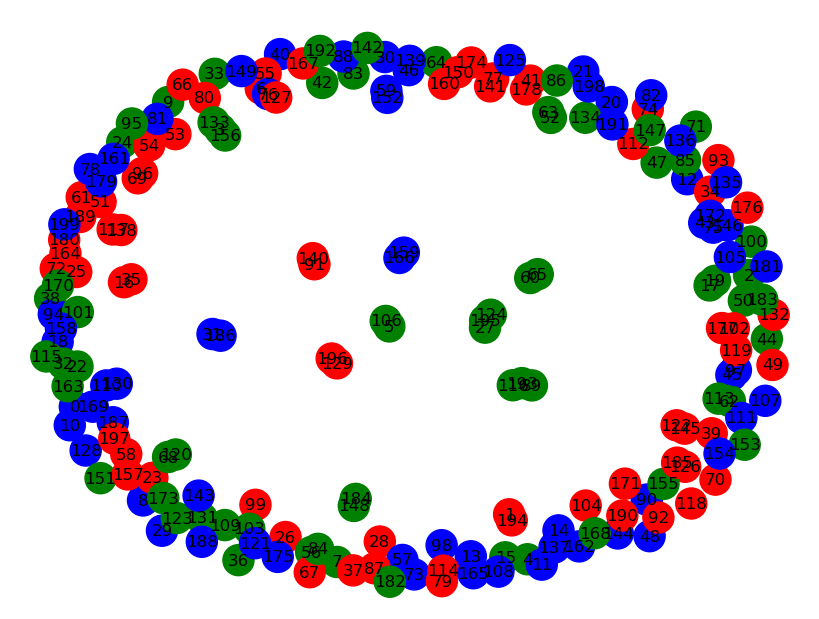

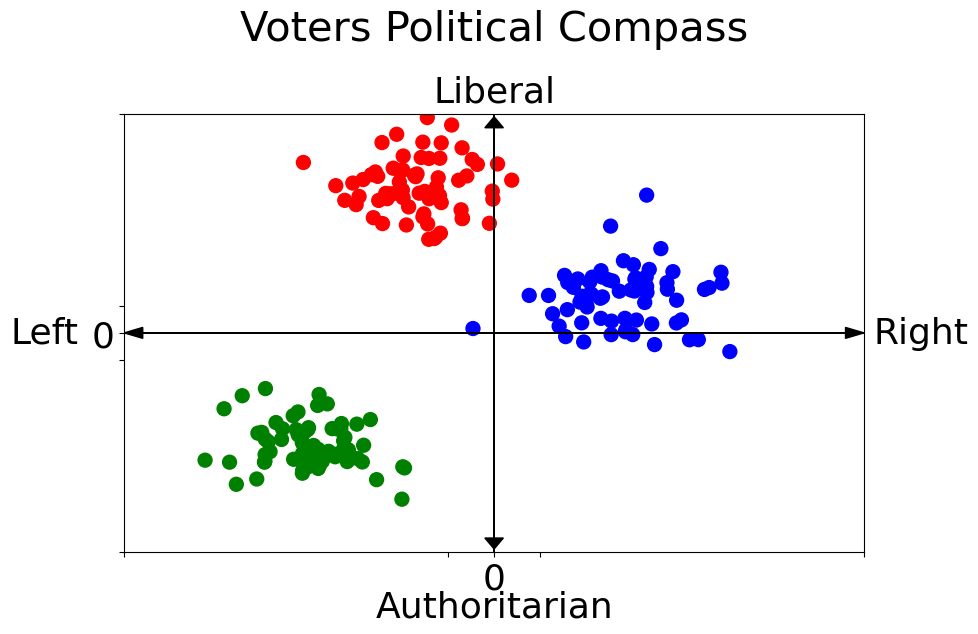

In [190]:
classes = ['Red', 'Blue', 'Green']
colors = {'Red': 'red', 'Blue': 'blue', 'Green': 'green'}
num_nodes=200
political_compass_graph = PoliticalCompassGraph(num_nodes=num_nodes, classes=classes, colors=colors,cluster_std=0.5, center_box=(-3.0, 3.0),  same_class_connection_prob=0.0, different_class_connection_prob=0.0, connection_randomness_factor=0.00, same_class_proximity_weight=0.01, different_class_proximity_weight=0.01) 
political_compass_graph.draw_graph()
political_compass_graph.plot_political_compass()

G, features, labels = political_compass_graph.get_graph(), political_compass_graph.get_features(), political_compass_graph.get_labels()

# Split the data
train_mask, test_mask = split_data(len(labels), train_percent=0.8)  # Change train_percent as needed

# Convert to PyTorch Geometric format
data = convert_to_torch_geometric(G, features, labels, train_mask, test_mask)

# Calculate the number of unique classes
num_classes = len(np.unique(labels))


In [191]:
def single_deterministic_model_prob(model, data):
    model.eval()
    with torch.no_grad():
        prediction = model(data)
        return prediction
    
def stochastic_model_prob(model, data, n_samples=100):
    model.eval()
    with torch.no_grad():
        _, samples_mean, _ = mc_sample_stats(model, data, n_samples=n_samples)
    return samples_mean


def ensemble_prob(models, data):
    predictions = []
    # Generate predictions from each model
    for model in models:
        output = model(data)
        predictions.append(output.data.cpu())

    # Aggregate predictions (e.g., using mean)
    ensemble_prediction = torch.mean(torch.stack(predictions), dim=0).to(device)
    return ensemble_prediction


def negative_log_likelihood(model, data, model_type):
    if model_type =='deterministic': 
        prob = single_deterministic_model_prob(model, data)
    elif model_type =='stochastic':
        prob = stochastic_model_prob(model, data, n_samples=100)
    elif model_type == 'ensemble':
        prob = ensemble_prob(model, data)
    else:
        raise ValueError(f"Invalid model_type: {model_type}. Supported values are 'stochastic', 'deterministic', or 'ensemble'.")

    correct_label_prob = prob[data.test_mask, data.y[data.test_mask]]  # Select the probabilities of the correct labels
    smoothed_prob = correct_label_prob + 1e-9  # Add a small constant to prevent taking the log of zero
    nll = -torch.log(smoothed_prob).mean()  # Take the log and negate it
    return nll



def evaluate_noise_resilience(noisy_test_data, num_experiments, G, features, labels, model_init_func, model_type):
    
    all_accuracies = {str(round(noise_level, 2)): [] for noise_level in noisy_test_data}

    for experiment_number in range(num_experiments):
        # Get data with the training percentages
        train_mask, test_mask = split_data(len(labels), train_percent=0.8)
        data = convert_to_torch_geometric(G, features, labels, train_mask, test_mask)

        _, model, = run_single_experiment(model_init_func, data, experiment_number, model_type, return_model=True)
            
        # Calculate test accuracy for each noise level
        for noise_level, noisy_features in noisy_test_data.items():
            # logging.info('~' * 10 + f' Model: {model_name}, noise_level: {noise_level}' + '~' * 10)
            noisy_features_tensor = torch.tensor(noisy_features, dtype=torch.float).to(data.x.device)  # Move to the same device as data.x
            data.x[data.test_mask] = noisy_features_tensor
            
            test_accuracy, num_pred = evaluate_model_type(model, data, model_type=model_type, entropy_threshold=np.inf) 

            
            nll = negative_log_likelihood(model, data, model_type)
            print(f'noise_level: {noise_level:.2f}', f'Number of Predictions: {num_pred}', f'Test accuracy: {test_accuracy:.2f}', f'nll: {nll:.2f}')

            # Store the results in the dictionary
            all_accuracies[str(round(noise_level, 2))].append(round(float(nll), 2))
            # print('nll', nll)
    
    return all_accuracies

In [192]:
def add_gaussian_noise(features, noise_level):
    noise = np.random.normal(0, noise_level, features.shape)
    return features + noise

def create_noisy_test_data(test_features, noise_levels):
    noisy_test_data = {}
    for noise_level in noise_levels:
        noisy_test_data[noise_level] = add_gaussian_noise(test_features, noise_level)
    return noisy_test_data

# Define the standard deviations for the Gaussian noise
noise_levels = np.linspace(0, 10, 101)  # 101 different noise levels from 0 to 10

# Store the original features for the test data
original_test_features = features[test_mask]

# Create noisy test data
noisy_test_data = create_noisy_test_data(original_test_features, noise_levels)

In [193]:
num_experiments = 100
noise_results_path = 'results/political_compass/noise'



In [194]:
# Model 3: GCN
model_name_gcn = 'gcn'
model_init_func_gcn = initialize_gcn_model

all_accuracies_gcn = evaluate_noise_resilience(noisy_test_data, num_experiments, G, features, labels, model_init_func_gcn, model_type='deterministic')
save_results(all_accuracies_gcn, model_name_gcn, noise_results_path)


INFO:root:---------- Experiment 1 ----------


Train Loss: -0.9923, Train Acc: 0.9938
Test Loss: -0.9998, Test Acc: 1.0000
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.03
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.42
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.35
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.82 nll: 0.74
noise_level: 1.10 Number of Predictions: 40 Test accuracy: 0.93 nll: 0.36
noise_level: 1.20 Number of Predicti

INFO:root:---------- Experiment 2 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.23
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.85
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.81
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.44
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.40
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.44
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.73
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.96
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.67
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.64
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.78
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.78
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.60
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 3 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.08
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.78
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.32
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.49
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.81
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.32
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.45
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.38
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.55
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.16
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.24
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.60
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.11
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 4 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.20
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.08
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.04
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.19
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.76
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.49
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.92
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.56
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 9.05
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.76
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.16
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.77
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.84
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 5 ----------


noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.46
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.68 nll: 4.60
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.48
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.78
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.97
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.02
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.78
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.21
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.00
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.61
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.64
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.74
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.63
noise_level: 7.30 Number of Prediction

INFO:root:---------- Experiment 6 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.18
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.79
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.73
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.03
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.88
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.94
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.95
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.95
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.56
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.62
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.54
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.09
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.70
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 7 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.13
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.96
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.61
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.91
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.69
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.77
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.00
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.87
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.89
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.12
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.15
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.60
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.05
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 8 ----------


noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.94
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.68 nll: 4.30
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.64
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.00
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.58
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.08
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.26
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.20
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.83
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.27
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.45
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.72
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.74
noise_level: 7.10 Number of Prediction

INFO:root:---------- Experiment 9 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.89
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.84
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.24
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.16
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.94
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.60
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.81
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.70
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.03
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.11
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.63
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.34
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.95
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 10 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.75
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.92
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.44
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.29
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.47
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.83
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.21
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.47 nll: 7.88
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.64
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.01
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 8.16
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.86
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.65
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 11 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.19
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.29
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 5.07
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.22
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.80
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.42
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.26
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 8.39
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.91
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.39
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.65
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 5.92
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.73
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 12 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.95
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.62
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.69
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.38
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.24
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.71
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.66
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.78
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.60
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.98
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.01
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.29
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.03
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 13 ----------


noise_level: 5.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.78
noise_level: 5.50 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.37
noise_level: 5.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.92
noise_level: 5.70 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.68
noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.47 nll: 9.42
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.77
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.18
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.18
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.60
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.57
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 9.43
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.45 nll: 10.59
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.29
noise_level: 6.70 Number of Predictio

INFO:root:---------- Experiment 14 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.42
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.22
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.80
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.39
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.65
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.35
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.18
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.93
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.30
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.44
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.07
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.58
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.49
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 15 ----------


noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.55
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 4.61
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.56
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.00
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.33
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.05
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.72
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.37
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.01
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 4.67
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.12
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.72
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.54
noise_level: 7.10 Number of Prediction

INFO:root:---------- Experiment 16 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.01
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.06
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.03
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.82
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.99
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.45
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.05
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.63
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.93
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.02
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.40
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 5.96
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.84
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 17 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.17
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.14
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.94
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.39
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.11
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.71
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.70
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.80
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.05
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.40
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.76
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.16
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.14
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 18 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.82
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.03
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.89
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.44
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.13
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.94
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.66
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.10
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.74
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.01
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.08
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.69
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.21
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 19 ----------


noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.04
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.70
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.17
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.92
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.22
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.74
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.86
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.35
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.65
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.71
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.50
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.74
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.04
noise_level: 7.60 Number of Prediction

INFO:root:---------- Experiment 20 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.65
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.24
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.01
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.56
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.44
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.21
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.92
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.01
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.82
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.10
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.27
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.93
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.23
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 21 ----------


noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.20
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.17
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.12
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.95
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.40
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.22
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 7.02
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.83
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.04
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.11
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.03
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.90
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.88
noise_level: 7.60 Number of Prediction

INFO:root:---------- Experiment 22 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.83
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.24
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.94
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.23
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.08
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 7.03
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.69
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.91
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.88
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.05
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.03
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.61
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.29
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 23 ----------


noise_level: 5.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.15
noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.69
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.68 nll: 4.30
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.80
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.68 nll: 4.65
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.83
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.20
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.22
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.35
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.91
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.33
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.59
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.81
noise_level: 7.00 Number of Prediction

INFO:root:---------- Experiment 24 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.07
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.91
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.20
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.16
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.64
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.65
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.72
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.88
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.87
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.87
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.62
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.83
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.07
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 25 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.41
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.04
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.57
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.37
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.83
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.53
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.83
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.81
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 9.05
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.00
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.30
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.30
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.95
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 26 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.10
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.12
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.99
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.65
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.66
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.69
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.68
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.03
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.97
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.45 nll: 8.36
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.44
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.05
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 5.77
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 27 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.21
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.95
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.10
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.55
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.75
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.56
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.72
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.79
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 7.99
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.12
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.51
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.04
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.10
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 28 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.98
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.81
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.42
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.10
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.67
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.86
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.07
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.68
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.64
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.06
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.51
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.38
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.35
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 29 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.34
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.64
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.87
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.52
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.65
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.98
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.48
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.83
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.12
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.99
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.35
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.90
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.20
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 30 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.07
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.35
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.39
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 5.53
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.50
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.14
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.29
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.32
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.90
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.96
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.72
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.30
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.57
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 31 ----------


noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.08
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.50
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.35
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.01
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.00
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.07
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.10
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.09
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.83
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.75
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.22
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.79
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.94
noise_level: 7.40 Number of Prediction

INFO:root:---------- Experiment 32 ----------


noise_level: 5.40 Number of Predictions: 40 Test accuracy: 0.75 nll: 3.73
noise_level: 5.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.03
noise_level: 5.60 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.08
noise_level: 5.70 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.17
noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.66
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.65 nll: 4.82
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.78
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.22
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.67
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.26
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.18
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.08
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.03
noise_level: 6.70 Number of Prediction

INFO:root:---------- Experiment 33 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.78
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.33
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.98
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.12
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.85
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.76
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.43
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.50
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.71
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.78
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.73
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.82
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 5.97
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 34 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.38
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.17
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.14
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.47
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.85
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.69
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.46
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.78
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.49
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.48
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.92
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.23
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 5.62
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 35 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.42 nll: 10.43
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.28
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.50 nll: 9.71
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.47 nll: 9.00
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.01
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.42 nll: 10.48
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.35 nll: 10.89
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.42 nll: 11.12
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.42
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.35 nll: 12.07
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.38 nll: 10.25
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.40 nll: 9.67
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.54
noise_level: 7.80 Number of Pred

INFO:root:---------- Experiment 36 ----------


noise_level: 5.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.10
noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.60
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.65 nll: 4.32
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.65
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.13
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.54
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.07
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.11
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.97
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.77
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.60
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.89
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.62
noise_level: 7.00 Number of Prediction

INFO:root:---------- Experiment 37 ----------


noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.47 nll: 7.76
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.45 nll: 8.70
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.47
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.93
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.45 nll: 8.46
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.98
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.24
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.47 nll: 7.15
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.42 nll: 9.30
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.33 nll: 9.90
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.42 nll: 10.20
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.12
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.38 nll: 10.92
noise_level: 7.50 Number of Predicti

INFO:root:---------- Experiment 38 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.41
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.94
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.50
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.41
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.79
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 8.30
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.78
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.97
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.95
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.40
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.74
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.25
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.59
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 39 ----------


noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.50
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.98
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.00
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.10
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.84
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.09
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.56
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.81
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.61
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.48
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.84
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.17
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.15
noise_level: 7.50 Number of Prediction

INFO:root:---------- Experiment 40 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.66
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.96
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 3.97
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.51
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.88
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.74
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.39
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.91
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.63
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.15
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.79
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.04
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.16
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 41 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.12
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.76
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.48
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.48
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.96
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.88
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.85
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.88
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.76
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.05
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.75
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.52
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.37
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 42 ----------


noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.08
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.24
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.65 nll: 4.97
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.65 nll: 4.62
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.54
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.09
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.09
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.10
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.31
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.82
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.15
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.93
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.30
noise_level: 7.10 Number of Prediction

INFO:root:---------- Experiment 43 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.16
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.90
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.23
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.52
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.81
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.88
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.76
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.95
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.89
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.06
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.55
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.54
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.14
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 44 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.31
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.25
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.67
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.58
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.48
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.22
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.39
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.60
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.64
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.75
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.39
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.44
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.79
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 45 ----------


noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.35
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.08
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.06
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.95
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.83
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.40
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.10
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.79
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.71
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.77
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.95
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.59
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.73
noise_level: 7.50 Number of Prediction

INFO:root:---------- Experiment 46 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.49
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.36
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.91
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.28
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.62
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.53
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.12
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.83
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.05
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.89
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.16
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.60
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.98
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 47 ----------


noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.28
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.47
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.49
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.98
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.43
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.93
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.85
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.17
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.07
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.58
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.19
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 8.11
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.97
noise_level: 7.60 Number of Prediction

INFO:root:---------- Experiment 48 ----------


noise_level: 5.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.25
noise_level: 5.60 Number of Predictions: 40 Test accuracy: 0.70 nll: 3.70
noise_level: 5.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.43
noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.55
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 4.57
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.74
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.09
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.39
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.19
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.06
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.28
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.09
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.40
noise_level: 6.80 Number of Prediction

INFO:root:---------- Experiment 49 ----------


noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.34
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.51
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.27
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.02
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.72
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.90
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.25
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.51
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.91
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.27
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.92
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.54
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.94
noise_level: 7.60 Number of Prediction

INFO:root:---------- Experiment 50 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.63
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.09
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.26
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.69
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.90
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.46
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.63
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.64
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 9.15
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.52
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.05
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.76
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.82
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 51 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.15
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.85
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.32
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.13
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.90
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.67
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.97
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.87
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.71
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.93
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.62
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.33
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.25
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 52 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.93
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.90
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.19
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.56
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.89
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.72
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.59
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.79
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.92
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.26
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.42
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.51
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.96
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 53 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.32
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.85
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.35
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.28
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.81
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.56
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.71
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.99
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.69
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.98
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.29
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.16
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 6.16
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 54 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.89
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.03
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.80
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.90
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.83
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 8.08
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.12
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 8.15
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.74
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.52
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.46
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.00
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.85
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 55 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.27
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.02
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.75
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.77
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.76
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.42
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.95
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.80
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.49
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.48
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.24
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.60
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 6.16
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 56 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.04
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.11
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.25
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.75
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 7.04
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.49
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.78
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.74
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.36
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.87
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.58
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 6.91
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.87
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 57 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.20
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.95
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.23
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.36
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 7.01
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.60
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.80
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.83
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.43
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.18
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.05
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.10
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.08
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 58 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.52
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.24
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.31
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.45
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.95
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.16
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.46
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.17
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 9.02
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.41
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.62
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.94
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.72
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 59 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.12
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.98
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.94
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.86
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.72
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.29
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.88
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.61
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.79
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.67
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.13
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 5.67
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.94
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 60 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.36
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.98
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.54
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.47
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.24
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.50
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.86
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.19
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.70
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.39
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.75
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.85
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.60
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 61 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.16
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.91
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.22
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.51
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.04
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.95
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.83
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.96
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.13
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.15
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.70
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.54
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.17
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 62 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.27
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.99
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.20
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.24
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.82
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.61
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.71
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.78
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.73
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.99
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.28
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.29
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.03
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 63 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.45
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.82
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.55
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.60
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.63
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.35
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.82
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.01
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.64
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.30
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.70
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.09
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.59
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 64 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.48
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.08
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.11
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.23
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.78
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.63
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.14
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.86
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.88
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.64
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.24
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.53
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 6.01
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 65 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.96
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.95
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.73
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.84
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.67
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.58
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.79
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.81
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.67
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.69
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.23
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 5.88
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.96
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 66 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.22
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.22
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.91
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 3.97
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.67
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.65
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.60
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.38
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.92
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.16
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.03
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.64
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 6.99
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 67 ----------


noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.69
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.21
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.72
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.27
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.05
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.62 nll: 7.14
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.99
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.53
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.01
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.96
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.83
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.13
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.99
noise_level: 7.30 Number of Prediction

INFO:root:---------- Experiment 68 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.51
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.10
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.18
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.64
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.08
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.18
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.84
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.93
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.33
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.28
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.78
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.08
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.05
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 69 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.37
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.95
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.37
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.78
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.98
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.19
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.99
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.21
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.09
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.08
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.93
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.60
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.42
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 70 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.83
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 5.93
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.58
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.38
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.98
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.85
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.42
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.59
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.70
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.76
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.17
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.32
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.91
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 71 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.33
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.10
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.66
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.82
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.91
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.85
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.04
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.05
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.99
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.52
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.53
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.81
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.08
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 72 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.21
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.93
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.62
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.79
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.93
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.73
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.33
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.97
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.12
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.53
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.87
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.77
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.37
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 73 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.92
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.91
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.56
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.46
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.93
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.91
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.11
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.98
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.58
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.11
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.24
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.27
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.43
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 74 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.15
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.88
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.40
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.14
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.63
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.50
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.74
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.93
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.51
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.69
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.17
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.98
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.74
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 75 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.23
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.04
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.61
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.87
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.79
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.63
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.98
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.87
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.64
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.75
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.33
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 5.93
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.17
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 76 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.49
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.93
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.06
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.90
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.70
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.58
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.61
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.72
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.59
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.82
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.89
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.13
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.89
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 77 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.26
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.83
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.56
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.47
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.78
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.23
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.90
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.07
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.66
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.16
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.79
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.77
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.62
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 78 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.92
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.81
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.27
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.44
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.88
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.60
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.84
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.78
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.24
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.13
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.68
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.06
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.23
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 79 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.47 nll: 9.22
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.14
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.94
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.49
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.12
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.58
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.84
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.22
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.33 nll: 10.80
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.38
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.83
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.40
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.17
noise_level: 7.80 Number of Predictio

INFO:root:---------- Experiment 80 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.30
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.98
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.27
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.96
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.89
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.43
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.80
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.75
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.69
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.86
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.16
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.22
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.93
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 81 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.98
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.88
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.33
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.38
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.84
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.84
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.78
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.06
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.43
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.97
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.27
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.70
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.27
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 82 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.32
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.00
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.78 nll: 4.25
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.82
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.72
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.96
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.84
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.32
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.54
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.17
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.10
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.83
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.07
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 83 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.33
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.06
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.52
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.71
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.83
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.38
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.72
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.71
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.78
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.53
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.00
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.62 nll: 5.69
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.78
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 84 ----------


noise_level: 5.70 Number of Predictions: 40 Test accuracy: 0.42 nll: 7.84
noise_level: 5.80 Number of Predictions: 40 Test accuracy: 0.47 nll: 6.74
noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.45 nll: 7.42
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.42 nll: 7.54
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.40 nll: 6.62
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.47 nll: 7.24
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.40 nll: 8.49
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.67
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.42 nll: 9.11
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.42 nll: 7.78
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.38
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.47 nll: 7.78
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.50 nll: 6.08
noise_level: 7.00 Number of Prediction

INFO:root:---------- Experiment 85 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.47
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.09
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.40
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.37
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.76
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.91
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.79
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.36
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.78
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.73
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.31
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.19
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.84
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 86 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.44
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.97
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.24
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.93
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.83
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 8.16
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.79
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.51
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.48
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 8.10
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.08
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.21
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.13
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 87 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.66
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.77
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.71
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.16
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.43
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.81
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.35
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.61
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.73
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.71
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.35
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.46
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.79
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 88 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.33
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.39
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.86
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.34
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.60
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.78
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.99
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.94
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.05
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.72
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.07
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.69
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.59
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 89 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.03
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.02
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.60
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.68
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.87
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.61
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.01
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.82
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.78
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.69
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.43
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 5.82
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.10
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 90 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.30
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.01
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.22
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.63
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 7.07
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.87
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.94
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.93
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.36
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.21
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.82
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.69
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.13
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 91 ----------


noise_level: 5.90 Number of Predictions: 40 Test accuracy: 0.57 nll: 4.79
noise_level: 6.00 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.48
noise_level: 6.10 Number of Predictions: 40 Test accuracy: 0.68 nll: 4.87
noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.26
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.17
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.98
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.35
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.93
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.28
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.07
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.46
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.60
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.95
noise_level: 7.20 Number of Prediction

INFO:root:---------- Experiment 92 ----------


noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.26
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.97
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.03
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.01
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.75
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.74
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.71
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.52
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.94
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.60
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.24
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.35
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.73
noise_level: 7.60 Number of Prediction

INFO:root:---------- Experiment 93 ----------


noise_level: 6.20 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.58
noise_level: 6.30 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.16
noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.43
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.42
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.92
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.13
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.73
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.73
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.90
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.62
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.22
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.13
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.07
noise_level: 7.50 Number of Prediction

INFO:root:---------- Experiment 94 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.35
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.93
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.11
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.22
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.88
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.76
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.76
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.05
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.48
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.83
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.89
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.56
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.12
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 95 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.31
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.91
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.54
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.58
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.08
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.12
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.16
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.06
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.53 nll: 8.06
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.17
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.99
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.62
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.51
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 96 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.40 nll: 10.69
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.35
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.50 nll: 9.56
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.99
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.08
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.42 nll: 10.35
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.35 nll: 10.76
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.42 nll: 11.38
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 7.96
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.35 nll: 11.74
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.38 nll: 10.45
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.40 nll: 9.92
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.45 nll: 9.77
noise_level: 7.80 Number of Pred

INFO:root:---------- Experiment 97 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.09
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 5.97
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 4.45
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.86
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.87
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.53
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.86
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.72
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.82
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.83
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.31
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 5.94
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.95
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 98 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.19
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.87
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.27
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.60
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.78
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.88
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.71
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.15
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.99
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.07
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.73
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.29
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.18
noise_level: 7.80 Number of Prediction

INFO:root:---------- Experiment 99 ----------


noise_level: 6.40 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.07
noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.04
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.88
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.75 nll: 4.27
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.46
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.86
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.71
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.86
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.88
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.13
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.08
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.75
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.24
noise_level: 7.70 Number of Prediction

INFO:root:---------- Experiment 100 ----------


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.26
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.96
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 4.18
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.56
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.91
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.83
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.79
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.00
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.47
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.55 nll: 8.08
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.05
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.57 nll: 6.94
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 6.06
noise_level: 7.80 Number of Prediction

INFO:root:Results saved to: results/political_compass/noise/accuracies_gcn_(1).json


noise_level: 6.50 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.26
noise_level: 6.60 Number of Predictions: 40 Test accuracy: 0.65 nll: 6.22
noise_level: 6.70 Number of Predictions: 40 Test accuracy: 0.70 nll: 5.04
noise_level: 6.80 Number of Predictions: 40 Test accuracy: 0.60 nll: 6.93
noise_level: 6.90 Number of Predictions: 40 Test accuracy: 0.62 nll: 6.92
noise_level: 7.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.70
noise_level: 7.10 Number of Predictions: 40 Test accuracy: 0.50 nll: 8.33
noise_level: 7.20 Number of Predictions: 40 Test accuracy: 0.60 nll: 7.73
noise_level: 7.30 Number of Predictions: 40 Test accuracy: 0.47 nll: 8.93
noise_level: 7.40 Number of Predictions: 40 Test accuracy: 0.50 nll: 7.68
noise_level: 7.50 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.41
noise_level: 7.60 Number of Predictions: 40 Test accuracy: 0.60 nll: 5.76
noise_level: 7.70 Number of Predictions: 40 Test accuracy: 0.68 nll: 5.98
noise_level: 7.80 Number of Prediction

In [195]:
# Model 1: Graph Neural SDE
model_name_sde = 'graph_neural_sde'
model_init_func_sde = initialize_graph_neural_sde 

all_accuracies_sde = evaluate_noise_resilience(noisy_test_data, num_experiments, G, features, labels, model_init_func_sde, model_type='stochastic')
save_results(all_accuracies_sde, model_name_sde, noise_results_path)

INFO:root:---------- Experiment 1 ----------
/scratch/rsb63/miniconda3/envs/gn-sde/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.29
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.24
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.44
noise_level: 1.10 Number of Predictions: 40 Test accuracy: 0.93 nll: 0.25
noise_level:

INFO:root:---------- Experiment 2 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 6.63
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.23
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.20
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.33
noise_level

INFO:root:---------- Experiment 3 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.86
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.04
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.05
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.28
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.23
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.43
noise_level

INFO:root:---------- Experiment 4 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 5.77
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.26
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.22
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.38
noise_level

INFO:root:---------- Experiment 5 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.95
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.27
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.24
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.40
noise_level

INFO:root:---------- Experiment 6 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.96
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.23
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.20
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.33
noise_level

INFO:root:---------- Experiment 7 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 6.97
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.25
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.23
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.36
noise_level

INFO:root:---------- Experiment 8 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.00
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.27
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.24
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.40
noise_level

INFO:root:---------- Experiment 9 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.04
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.26
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.24
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.35
noise_level

INFO:root:---------- Experiment 10 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 6.15
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.24
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.22
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.33
noise_level

INFO:root:---------- Experiment 11 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.19
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.25
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.24
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.82 nll: 0.35
noise_level

INFO:root:---------- Experiment 12 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.52
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.27
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.24
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.42
noise_level

INFO:root:---------- Experiment 13 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 6.20
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.25
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.23
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.37
noise_level

INFO:root:---------- Experiment 14 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.08
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.25
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.22
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.38
noise_level

INFO:root:---------- Experiment 15 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 6.71
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.24
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.21
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.36
noise_level

INFO:root:---------- Experiment 16 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 6.45
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.25
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.21
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.38
noise_level

INFO:root:---------- Experiment 17 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.88
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.23
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.20
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.30
noise_level

INFO:root:---------- Experiment 18 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.27
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.25
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.22
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.39
noise_level

INFO:root:---------- Experiment 19 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.60 nll: 5.70
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.24
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.20
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.37
noise_level

INFO:root:---------- Experiment 20 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 7.47
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.27
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.24
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.82 nll: 0.40
noise_level

INFO:root:---------- Experiment 21 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.57 nll: 7.13
Train Accuracy: 0.6438, Number of Predictions: 160
Test Accuracy: 0.7500, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 0.75 nll: 1.69
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 0.75 nll: 1.66
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 0.75 nll: 1.72
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 0.75 nll: 1.70
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 0.75 nll: 1.68
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 0.75 nll: 1.74
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 0.75 nll: 1.66
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.72 nll: 2.02
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.68 nll: 2.03
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.68 nll: 2.09
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.65 nll: 2.59
noise_level

INFO:root:---------- Experiment 22 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.50 nll: 6.60
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.03
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.28
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.23
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.82 nll: 0.42
noise_level

INFO:root:---------- Experiment 23 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 6.33
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.02
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.25
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.22
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.34
noise_level

INFO:root:---------- Experiment 24 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 7.00
Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 1.0000, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.00
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.03
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 1.00 nll: 0.01
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.04
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.27
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.24
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.85 nll: 0.44
noise_level

In [ ]:
# Model 5: Bayesian GCN 
model_name_bayesian_gcn = 'bayesian_graph_gcn' 
model_init_func_bayes = initialize_bayesian_gcn_model

all_accuracies_ode = evaluate_noise_resilience(noisy_test_data, num_experiments, G, features, labels, model_init_func_bayes, model_type='stochastic')
save_results(model_name_bayesian_gcn, bayes_gcn_model, entropy_results_path)

INFO:root:---------- Experiment 1 ----------


Train Accuracy: 0.9938, Number of Predictions: 160
Test Accuracy: 0.9750, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.10
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.11
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.13
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.16
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.95 nll: 0.16
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.27
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.93 nll: 0.23
noise_level: 1.10 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.35
noise_level:

INFO:root:---------- Experiment 2 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 4.32
Train Accuracy: 0.9812, Number of Predictions: 160
Test Accuracy: 0.9750, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.10
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.10
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.11
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.13
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.16
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.95 nll: 0.18
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.28
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.93 nll: 0.22
noise_level

INFO:root:---------- Experiment 3 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.53 nll: 4.68
Train Accuracy: 0.9875, Number of Predictions: 160
Test Accuracy: 0.9750, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.10
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.10
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.10
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.09
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.11
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.14
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.16
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.95 nll: 0.16
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.27
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.93 nll: 0.23
noise_level

INFO:root:---------- Experiment 4 ----------


noise_level: 10.00 Number of Predictions: 40 Test accuracy: 0.55 nll: 4.49
Train Accuracy: 0.9875, Number of Predictions: 160
Test Accuracy: 0.9750, Number of Predictions: 40
noise_level: 0.00 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.13
noise_level: 0.10 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.12
noise_level: 0.20 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.12
noise_level: 0.30 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.13
noise_level: 0.40 Number of Predictions: 40 Test accuracy: 0.97 nll: 0.12
noise_level: 0.50 Number of Predictions: 40 Test accuracy: 0.95 nll: 0.14
noise_level: 0.60 Number of Predictions: 40 Test accuracy: 0.95 nll: 0.17
noise_level: 0.70 Number of Predictions: 40 Test accuracy: 0.95 nll: 0.18
noise_level: 0.80 Number of Predictions: 40 Test accuracy: 0.95 nll: 0.18
noise_level: 0.90 Number of Predictions: 40 Test accuracy: 0.90 nll: 0.33
noise_level: 1.00 Number of Predictions: 40 Test accuracy: 0.88 nll: 0.27
noise_level

KeyboardInterrupt: 

In [ ]:
# Model 2: Graph Neural ODE
model_name_ode = 'graph_neural_ode' 
model_init_func_ode = initialize_graph_neural_ode

all_accuracies_ode = evaluate_noise_resilience(noisy_test_data, num_experiments, G, features, labels, model_init_func_ode, model_type='deterministic')
save_results(all_accuracies_ode, model_name_ode, noise_results_path)

: 

In [ ]:
# # Model 3: GCN
# model_name_gcn = 'gcn'
# model_init_func_gcn = initialize_gcn_model

# all_accuracies_gcn = evaluate_noise_resilience(noisy_test_data, num_experiments, G, features, labels, model_init_func_gcn, model_type='deterministic')
# save_results(all_accuracies_gcn, model_name_gcn, noise_results_path)


: 

In [ ]:
# Model 4: Ensemble of GCN
model_name_ensemble = 'ensemble_of_gcn'
model_init_func_ensemble = initialize_gcn_model

all_accuracies_ensemble = evaluate_noise_resilience(noisy_test_data, num_experiments, G, features, labels, model_init_func_ensemble, model_type='ensemble')
save_results(all_accuracies_ensemble, model_name_ensemble, noise_results_path)

: 

: 

# Plots

In [40]:


import json
import os
import numpy as np

def compute_mean_std(dictionary):
    results = {}
    for key, values in dictionary.items():
        # Filter out None and non-numeric values
        valid_values = [x for x in values if isinstance(x, (int, float))]

        if valid_values:
            mean = np.mean(valid_values)
            std = np.std(valid_values)
            results[key] = {'mean': mean, 'std': std}
        else:
            print(f"Warning: Key '{key}' does not contain valid numeric values.")
    return results



def load_json_file(results_path, file_name):
    file_path = os.path.join(results_path, file_name)
    with open(file_path, 'r') as file:
        return json.load(file)
    
    
# Define a professional color palette
colors = {'gn-sde (OUR)': '#82cbb2', 'gcn': '#98568d', 'gn-ode': '#108da3', 'ensemble GCN': "#4682b4", "bayesian GCN": "#e67e22"}





### Uncertainty Quantification Plots

In [41]:

results_sde = "accuracies_graph_neural_sde.json"
results_gcn = 'accuracies_gcn.json'
results_ode = 'accuracies_graph_neural_ode.json'
results_bayesian_gcn = "accuracies_bayesian_graph_gcn.json"
results_ensemble = "accuracies_ensemble_of_gcn.json"


# Usage
results_path = 'results/political_compass/uncertainty_quantification/'



# Define paths to the result files
results_files = {
    'gn-sde (OUR)': "accuracies_graph_neural_sde.json",
    'gcn': 'accuracies_gcn.json',
    'gn-ode': 'accuracies_graph_neural_ode.json',
    'bayesian GCN': "accuracies_bayesian_graph_gcn.json",
    'ensemble GCN': "accuracies_ensemble_of_gcn.json"
}

# Define the path where result files are stored
results_path = 'results/political_compass/uncertainty_quantification/'


# Load and compute mean/std for each result file
results = {}
for model, file_name in results_files.items():
    data = load_json_file(results_path, file_name)
    results[model] = compute_mean_std(data)


In [7]:
# Collect all unique entropy threshold values across all models
all_entropies = set()
for model_results in results.values():
    all_entropies.update(model_results.keys())
all_entropies = sorted([float(entropy) for entropy in all_entropies])

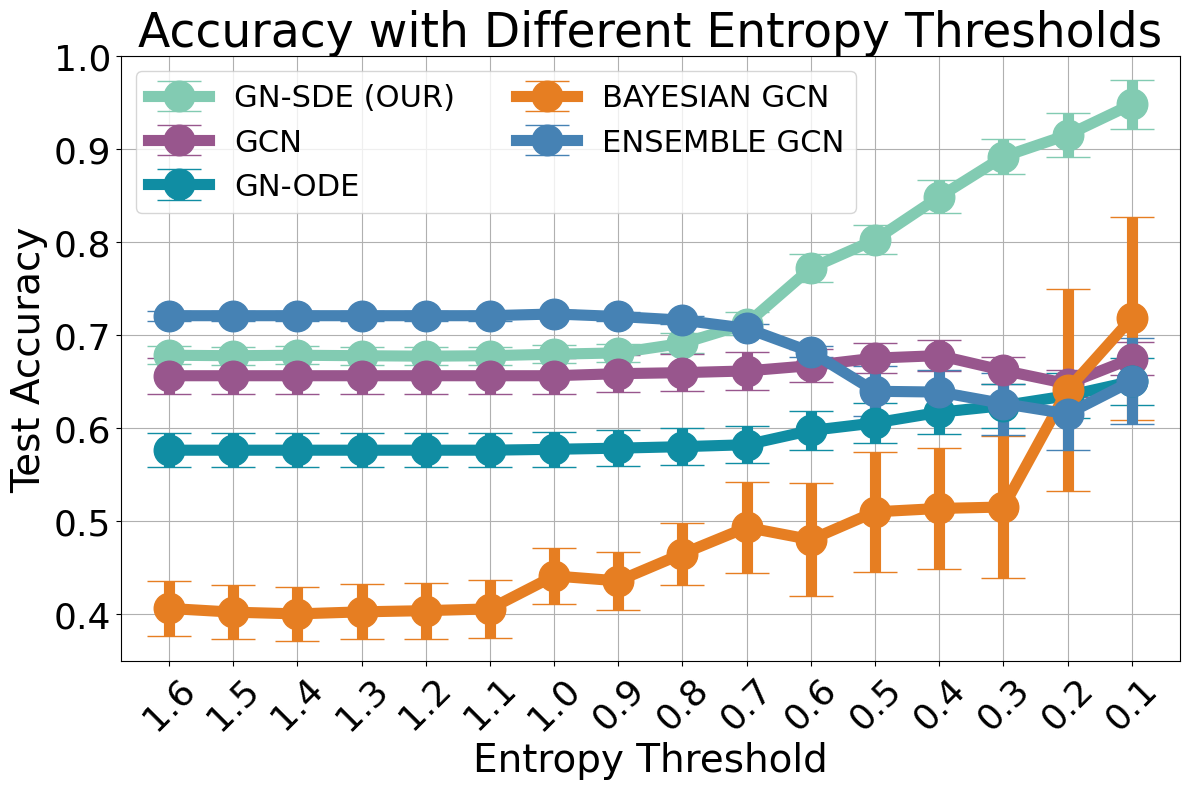

In [8]:
import matplotlib.pyplot as plt

# Define a professional color palette
colors = {
    'gn-sde (OUR)': 'navy',
    'gcn': 'darkgreen',
    'gn-ode': 'darkorange',
    'bayesian GCN': 'darkred',
    'ensemble GCN': 'purple'
}
colors = {'gn-sde (OUR)': '#82cbb2', 'gcn': '#98568d', 'gn-ode': '#108da3', 'ensemble GCN': "#4682b4", "bayesian GCN": "#e67e22"}

def plot_results(results, label, color):
    entropies = [float(key) for key in results.keys()]
    mean_accuracies = [results[key]['mean'] for key in results.keys()]
    std_devs = [results[key]['std']**2 for key in results.keys()]
    plt.errorbar(entropies, mean_accuracies, yerr=std_devs, fmt='-o',  linewidth=8, capsize=16, markersize=22, label=label, color=color)

plt.figure(figsize=(12, 8))


# Plotting each model
for model, model_results in results.items():
    plot_results(model_results, f"{model.upper()}", colors[model])
    

    
plt.xlabel('Entropy Threshold', fontsize=28)
plt.ylabel('Test Accuracy', fontsize=28)
plt.title('Accuracy with Different Entropy Thresholds', fontsize=34)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.xticks(all_entropies, rotation=45)  # Rotate x-axis labels to make them readable
plt.legend(fontsize=22, ncol=2)
plt.grid(True)
plt.gca().invert_xaxis()  # Reverse the x-axis
plt.ylim(0.35, 1)
plt.tight_layout()  # Adjust the padding between and around subplots.


# Specify the path where you want to save the figure
save_path = 'results/political_compass/uncertainty_quantification/political_compass_uq.png'

# Save the figure
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()





## Training Percentage

In [42]:
results_sde = "accuracies_graph_neural_sde.json"
results_gcn = 'accuracies_gcn.json'
results_ode = 'accuracies_graph_neural_ode.json'
results_bayesian_gcn = "accuracies_bayesian_graph_gcn.json"
results_ensemble = "accuracies_ensemble_of_gcn.json"


# Usage 
results_path = 'results/political_compass/training_percentages/'



# Define paths to the result files
results_files = {
    'gn-sde (OUR)': "accuracies_graph_neural_sde.json",
    'gcn': 'accuracies_gcn.json',
    'gn-ode': 'accuracies_graph_neural_ode.json',
    'bayesian GCN': "accuracies_bayesian_graph_gcn.json",
    'ensemble GCN': "accuracies_ensemble_of_gcn.json"
}



# Load and compute mean/std for each result file
results = {}
for model, file_name in results_files.items():
    data = load_json_file(results_path, file_name)
    results[model] = compute_mean_std(data)


In [43]:

def compute_mean_std(dictionary):
    results = {}
    for key, values in dictionary.items():
        # Filter out None and non-numeric values
        valid_values = [x for x in values if isinstance(x, (int, float))]
        if valid_values:
            mean = np.mean(valid_values)
            std = np.std(valid_values)
            results[key] = {'mean': mean, 'std': std}
        else:
            print(f"Warning: Key '{key}' does not contain valid numeric values.")
    return results

def load_json_file(results_path, file_name):
    file_path = os.path.join(results_path, file_name)
    with open(file_path, 'r') as file:
        return json.load(file)
    
    



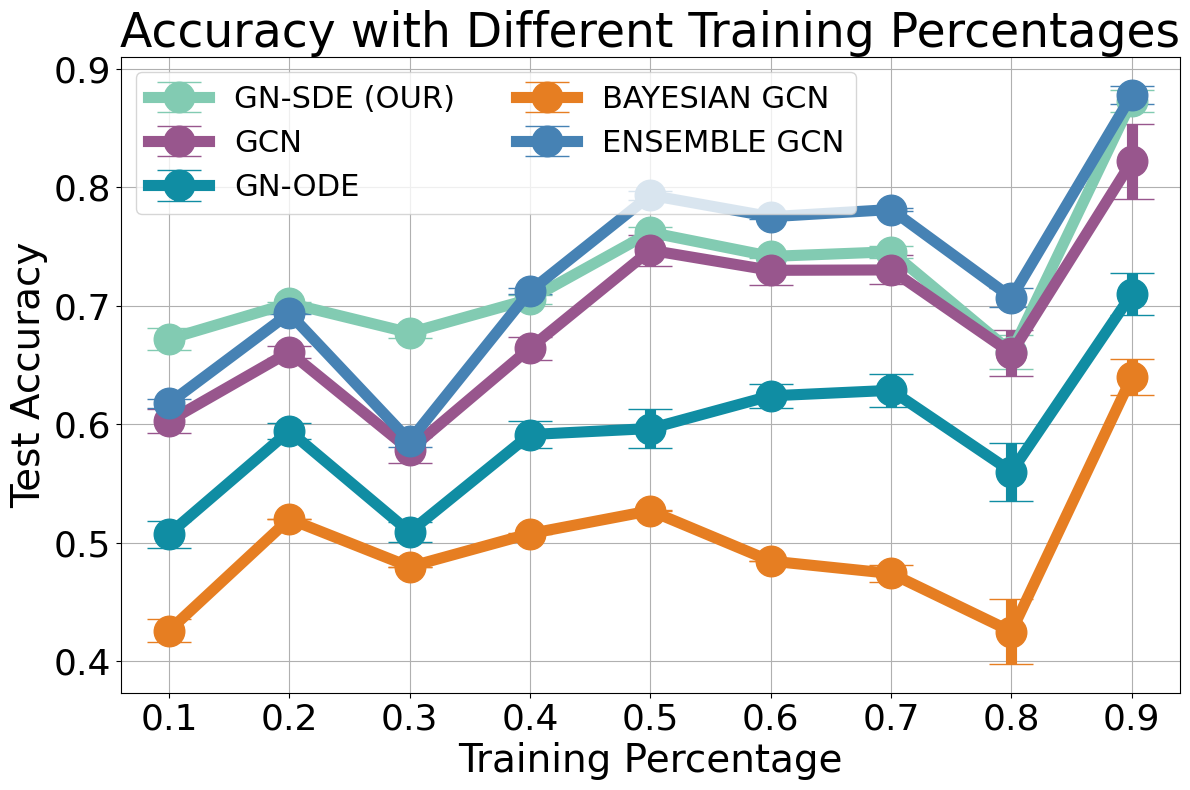

In [44]:
import matplotlib.pyplot as plt


def plot_results(results, label, color):
    train_per = [float(key) for key in results.keys()]
    mean_accuracies = [results[key]['mean'] for key in results.keys()]
    std_devs = [results[key]['std']**2 for key in results.keys()]
    plt.errorbar(train_per, mean_accuracies, yerr=std_devs, fmt='-o',  linewidth=8, capsize=16, markersize=22, label=label, color=color)

plt.figure(figsize=(12, 8))


# Plotting each model
for model, model_results in results.items():
    plot_results(model_results, f"{model.upper()}", colors[model])
    

    
plt.xlabel('Training Percentage', fontsize=28)
plt.ylabel('Test Accuracy', fontsize=28)
plt.title('Accuracy with Different Training Percentages', fontsize=34)
plt.tick_params(axis='both', which='major', labelsize=26)
# plt.xticks(all_entropies, rotation=45)  # Rotate x-axis labels to make them readable
plt.legend(fontsize=22, ncol=2)
plt.grid(True)
# plt.ylim(0.35, 1)
plt.tight_layout()  # Adjust the padding between and around subplots.


# Specify the path where you want to save the figure
save_path = 'results/political_compass/training_percentages/training_percentages.png'

# Save the figure
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()





## Noise

In [108]:
results_sde = "accuracies_graph_neural_sde.json"
results_gcn = 'accuracies_gcn.json'
results_ode = 'accuracies_graph_neural_ode.json'
results_bayesian_gcn = "accuracies_bayesian_graph_gcn.json"
results_ensemble = "accuracies_ensemble_of_gcn.json"


# Usage 
results_path = 'results/political_compass/noise/'



# Define paths to the result files
results_files = {
    'gn-sde (OUR)': "accuracies_graph_neural_sde.json",
    'gcn': 'accuracies_gcn.json',
    'gn-ode': 'accuracies_graph_neural_ode.json',
    'bayesian GCN': "accuracies_bayesian_graph_gcn.json",
    'ensemble GCN': "accuracies_ensemble_of_gcn.json"
}



# Load and compute mean/std for each result file
results = {}
for model, file_name in results_files.items():
    data = load_json_file(results_path, file_name)
    results[model] = compute_mean_std(data)


filtered_data = {}
mode = 0.2
for model, points in results.items():
    filtered_data[model] = {point: value for point, value in points.items() if float(f"{(float(point) % mode):.3g}") % mode == 0.0}

# Now, filtered_data contains only the points at intervals of 0.5
filtered_data

{'gn-sde (OUR)': {'0.0': {'mean': 0.07409999999999999,
   'std': 0.42044522829971576},
  '0.2': {'mean': 0.08099999999999997, 'std': 0.41970584937548816},
  '0.4': {'mean': 0.07969999999999997, 'std': 0.4116101432180699},
  '0.6': {'mean': 0.08129999999999996, 'std': 0.417455758134919},
  '0.8': {'mean': 0.3223, 'std': 0.39637067247716495},
  '1.0': {'mean': 0.45270000000000005, 'std': 0.4523778398639791},
  '1.2': {'mean': 0.3008, 'std': 0.4484767106550796},
  '1.4': {'mean': 0.618, 'std': 0.43674248705616},
  '1.6': {'mean': 0.6332000000000001, 'std': 0.4280441098765407},
  '1.8': {'mean': 0.242, 'std': 0.4900795853736411},
  '2.0': {'mean': 1.5858, 'std': 0.426411022371608},
  '2.4': {'mean': 1.8401999999999998, 'std': 0.4448122750104812},
  '2.6': {'mean': 1.548, 'std': 0.40022993391299455},
  '2.8': {'mean': 1.1229, 'std': 0.48166439561171637},
  '3.0': {'mean': 1.5744, 'std': 0.4169611972354262},
  '3.2': {'mean': 3.1190999999999995, 'std': 0.4417173191080468},
  '3.4': {'mean': 

In [109]:
results = filtered_data

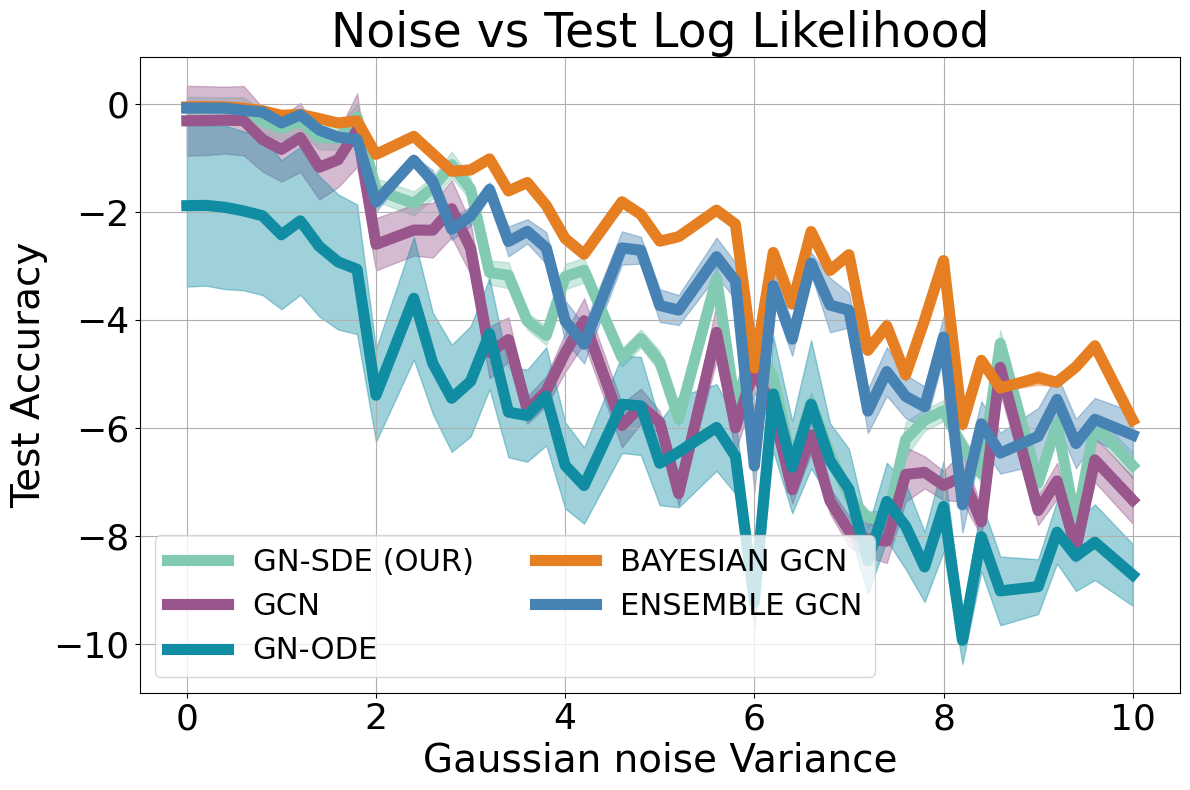

In [114]:
import matplotlib.pyplot as plt


def plot_results(results, label, color):
    train_per = np.array([float(key) for key in results.keys()])
    mean_accuracies = np.array([-results[key]['mean'] for key in results.keys()])
    std_devs = np.array([results[key]['std']/2 for key in results.keys()])
    # plt.errorbar(train_per, mean_accuracies, yerr=std_devs, fmt='-',  linewidth=8, capsize=2, markersize=2, label=label, color=color)
    plt.plot(train_per, mean_accuracies, label=label, color=color, linewidth=8)  # Mean line
    plt.fill_between(train_per, mean_accuracies - std_devs, mean_accuracies + std_devs, color=color, alpha=0.4)  # Variance shading


plt.figure(figsize=(12, 8))


# Plotting each model
for model, model_results in results.items():
    plot_results(model_results, f"{model.upper()}", colors[model])
    

    
plt.xlabel('Gaussian noise Variance', fontsize=28)
plt.ylabel('Test Accuracy', fontsize=28)
plt.title('Noise vs Test Log Likelihood', fontsize=34)
plt.tick_params(axis='both', which='major', labelsize=26)
# plt.xticks(all_entropies, rotation=45)  # Rotate x-axis labels to make them readable
plt.legend(fontsize=22, ncol=2)
plt.grid(True)
# plt.ylim(0.35, 1)
plt.tight_layout()  # Adjust the padding between and around subplots.


# Specify the path where you want to save the figure
save_path = 'results/political_compass/noise/noise.png'

# Save the figure
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()





# Scalability

In [116]:
# import json
# import os
# import re
# import shutil

# def combine_and_move_json_files(directory, old_directory='old'):
#     """
#     Combine JSON files in a given directory for each unique file name pattern and move processed files to 'old' directory.

#     Args:
#     directory (str): Directory where the files are located.
#     old_directory (str): Directory where processed files will be moved.

#     Returns:
#     dict: Dictionary with combined data for each unique file name pattern.
#     """
#     combined_data = {}
#     file_patterns = set()

#     # Create 'old' directory if it doesn't exist
#     old_directory_path = os.path.join(directory, old_directory)
#     if not os.path.exists(old_directory_path):
#         os.makedirs(old_directory_path)

#     # Identify unique file name patterns
#     for file in os.listdir(directory):
#         if file.endswith('.json'):
#             pattern = re.sub(r'(\_\(\d+\))?\.json$', '', file)
#             file_patterns.add(pattern)

#     # Combine files for each pattern and move processed files
#     for pattern in file_patterns:
#         pattern_data = {}
#         for file in os.listdir(directory):
#             if file.startswith(pattern) and file.endswith('.json'):
#                 file_path = os.path.join(directory, file)
#                 with open(file_path, 'r') as f:
#                     data = json.load(f)
#                 for key, values in data.items():
#                     pattern_data.setdefault(key, []).extend(values)

#                 # Move the file to 'old' directory
#                 shutil.move(file_path, old_directory_path)

#         combined_data[pattern] = pattern_data

#     return combined_data

# Example usage
# Replace 'your_actual_directory_path' with the actual path
# directory_path = 
# combined_data = combine_and_move_json_files(directory_path)
# print(combined_data)

# save_as_mapper = {
#     'accuracies_graph_neural_sde': "graph_neural_sde",
#     'accuracies_gcn': 'gcn',
#     'accuracies_graph_neural_ode': 'graph_neural_ode',
#     'accuracies_bayesian_graph_gcn': "bayesian_graph_gcn",
#     'accuracies_ensemble_of_gcn': "ensemble_of_gcn"
# }


# scalability_results_path = 'results/political_compass/scalability'

# for name in combined_data.keys():
#     results = combined_data[name]
#     save_name = save_as_mapper[name]
#     save_results(results, name, scalability_results_path)


In [117]:
results_sde = "accuracies_graph_neural_sde.json"
results_gcn = 'accuracies_gcn.json'
results_ode = 'accuracies_graph_neural_ode.json'
results_bayesian_gcn = "accuracies_bayesian_graph_gcn.json"
results_ensemble = "accuracies_ensemble_of_gcn.json"


# Usage 
results_path = 'results/political_compass/scalability/'



# Define paths to the result files
results_files = {
    'gn-sde (OUR)': "accuracies_accuracies_graph_neural_sde.json",
    'gcn': 'accuracies_accuracies_gcn.json',
    'gn-ode': 'accuracies_accuracies_graph_neural_ode.json',
    'bayesian GCN': "accuracies_accuracies_bayesian_graph_gcn.json",
    'ensemble GCN': "accuracies_accuracies_ensemble_of_gcn.json"
}



# Load and compute mean/std for each result file
results = {}
for model, file_name in results_files.items():
    data = load_json_file(results_path, file_name)
    results[model] = compute_mean_std(data)


In [121]:
results['ensemble GCN']

{'0.1': {'mean': 0.6099999999999999, 'std': 0.05992794026738578},
 '0.2': {'mean': 0.6937499999999999, 'std': 0.012808688457449478},
 '0.3': {'mean': 0.5542857142857142, 'std': 0.07727501906456298},
 '0.4': {'mean': 0.7058333333333333, 'std': 0.0606160503130611},
 '0.5': {'mean': 0.786, 'std': 0.07405403432629445},
 '0.6': {'mean': 0.7850000000000001, 'std': 0.030000000000000006},
 '0.7': {'mean': 0.7800000000000001, 'std': 0.04000000000000003},
 '0.8': {'mean': 0.7374999999999999, 'std': 0.026809513236909027},
 '0.9': {'mean': 0.8999999999999998, 'std': 2.220446049250313e-16}}

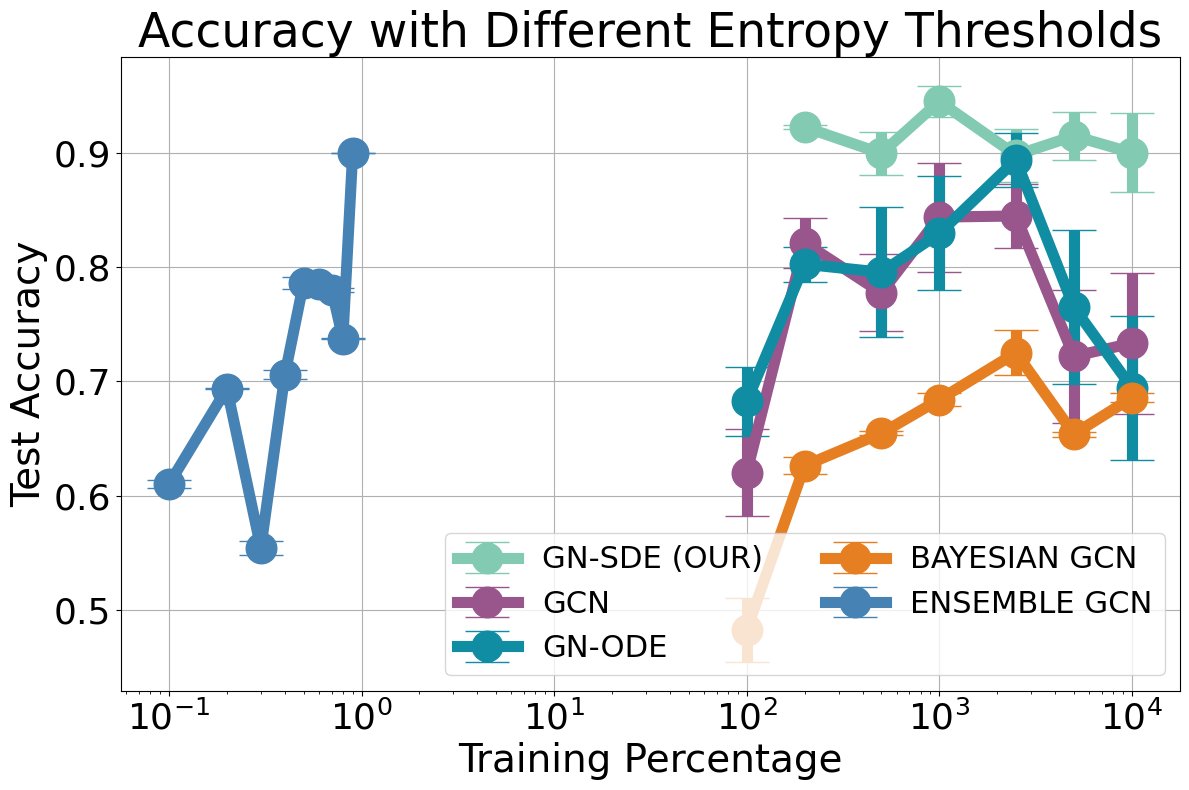

In [118]:
import matplotlib.pyplot as plt


def plot_results(results, label, color):
    train_per = [float(key) for key in results.keys()]
    mean_accuracies = [results[key]['mean'] for key in results.keys()]
    std_devs = [results[key]['std']**2 for key in results.keys()]
    plt.errorbar(train_per, mean_accuracies, yerr=std_devs, fmt='-o',  linewidth=8, capsize=16, markersize=22, label=label, color=color)

plt.figure(figsize=(12, 8))


# Plotting each model
for model, model_results in results.items():
    plot_results(model_results, f"{model.upper()}", colors[model])
    

    
plt.xlabel('Training Percentage', fontsize=28)
plt.ylabel('Test Accuracy', fontsize=28)
plt.title('Accuracy with Different Entropy Thresholds', fontsize=34)
plt.tick_params(axis='both', which='major', labelsize=26)
# plt.xticks(all_entropies, rotation=45)  # Rotate x-axis labels to make them readable
plt.legend(fontsize=22, ncol=2)
plt.grid(True)
# plt.ylim(0.35, 1)

# Set the x-axis to log scale
plt.xscale('log')

plt.tight_layout()  # Adjust the padding between and around subplots.


# # Specify the path where you want to save the figure
# save_path = 'results/political_compass/training_percentages/training_percentages.png'

# # Save the figure
# plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()





In [152]:

results_sde = "accuracies_graph_neural_sde.json"
results_gcn = 'accuracies_gcn.json'
results_ode = 'accuracies_graph_neural_ode.json'
results_bayesian_gcn = "accuracies_bayesian_graph_gcn.json"
results_ensemble = "accuracies_ensemble_of_gcn.json"


# Usage
results_path = 'results/political_compass/scalability/'

results_sde = load_json_file(results_path, results_sde)
results_gcn = load_json_file(results_path, results_gcn)
results_ode = load_json_file(results_path, results_ode)  # Assuming different file name is intended
results_bayesian_gcn = load_json_file(results_path, results_bayesian_gcn)  # Assuming different file name is intended
results_ensemble = load_json_file(results_path, results_ensemble)

# Now results_sde, results_gcn, results_ode, results_bayesian_gcn, and results_ensemble are dictionaries containing the JSON data


results_sde = compute_mean_std(results_sde)
results_gcn = compute_mean_std(results_gcn)
results_ode = compute_mean_std(results_ode)
results_bayesian_gcn = compute_mean_std(results_bayesian_gcn)
results_ensemble = compute_mean_std(results_ensemble)

FileNotFoundError: [Errno 2] No such file or directory: 'results/political_compass/scalability/accuracies_graph_neural_sde.json'

In [ ]:
# entropy_thresholds = [float(key) for key in list(results_sde.keys())]

: 

In [ ]:
# plt.figure(figsize=(10, 6))

# plt.plot(entropy_thresholds, gn_ode_accuracies, marker='o',  label='Graph Neural ODE', linewidth=8,markersize=16, color=colors['ode'])
# plt.plot(entropy_thresholds, gnn_accuracies, marker='o',  label='GCN', linewidth=8, markersize=15, color=colors['gnn'])
# plt.plot(entropy_thresholds, gn_sde_accuracies, marker='o', label='Graph Neural SDE', linewidth=8, markersize=16, color=colors['sde'])

# plt.xlabel('Entropy Threshold', fontsize=26)
# plt.ylabel('Test Accuracy', fontsize=26)
# plt.title('Accuracy with Different Entropy Thresholds', fontsize=30)
# plt.tick_params(axis='both', which='major', labelsize=26)  # Adjust the fontsize as needed

# plt.legend(fontsize=20)
# plt.grid(True)
# # Reverse the x-axis
# plt.xlim(max(entropy_thresholds), min(entropy_thresholds))
# plt.savefig('figures/acc_vs_entr_thresh.png', format='png', dpi=300, bbox_inches='tight')

# plt.show()


: 

In [ ]:
import json
import os

def load_json_file(results_path, file_name):
    file_path = os.path.join(results_path, file_name)
    with open(file_path, 'r') as file:
        return json.load(file)

# Usage
results_path = 'results/political_compass/noise/'

results_sde = load_json_file(results_path, "accuracies_graph_neural_sde.json")
results_gcn = load_json_file(results_path, 'accuracies_bayesian_graph_gcn.json')
results_ode = load_json_file(results_path, 'accuracies_bayesian_graph_gcn.json')  # Assuming different file name is intended
results_bayesian_gcn = load_json_file(results_path, "accuracies_bayesian_graph_gcn.json")  # Assuming different file name is intended
results_ensemble = load_json_file(results_path, "accuracies_ensemble_of_gcn.json")

# Now results_sde, results_gcn, results_ode, results_bayesian_gcn, and results_ensemble are dictionaries containing the JSON data


: 

In [ ]:
import numpy as np
def compute_mean_std(dictionary):
    results = {}
    for key, values in dictionary.items():
        # Ensure values are a list of numbers
        if isinstance(values, list) and all(isinstance(x, (int, float)) for x in values):
            mean = np.mean(values)
            std = np.std(values)
            results[key] = {'mean': mean, 'std': std}
        else:
            print(f"Warning: Key '{key}' does not contain a list of numbers.")
    return results

: 

In [ ]:
compute_mean_std(results_gcn)

: 

In [ ]:
import matplotlib.pyplot as plt


def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

window_size = 10

# Extract noise levels and log likelihoods from the results dictionary
noise_levels = [key for key in results_ode.keys()]
log_likelihoods_ode = [results_ode[key]['nll'] for key in results_ode.keys()]
log_likelihoods_gdn = [results_gcn[key]['nll'] for key in results_ode.keys()]
log_likelihoods_sde = [results_sde[key]['nll'] for key in results_ode.keys()]


ode_log_likelihoods_moving_avg = moving_average(log_likelihoods_ode, window_size)
ode_log_likelihoods_moving_avg = [-x for x in ode_log_likelihoods_moving_avg]

gcn_log_likelihoods_moving_avg = moving_average(log_likelihoods_gdn, window_size)
gcn_log_likelihoods_moving_avg = [-x for x in gcn_log_likelihoods_moving_avg]

sde_log_likelihoods_moving_avg = moving_average(log_likelihoods_sde, window_size)
sde_log_likelihoods_moving_avg = [-x for x in sde_log_likelihoods_moving_avg]
# Create the plot
plt.figure(figsize=(10, 6))
colors = {'sde': '#82cbb2', 'gnn': '#98568d', 'ode': '#108da3', 'ensemble': "#108da3", "bnn": "#e67e22"}
plt.plot(noise_levels[window_size-1:], ode_log_likelihoods_moving_avg, label='Graph Neural ODE', linewidth=8, color=colors['ode'])
plt.plot(noise_levels[window_size-1:], gcn_log_likelihoods_moving_avg, label='GCN', linewidth=8, color=colors['gnn'])
plt.plot(noise_levels[window_size-1:], sde_log_likelihoods_moving_avg, label='Graph Neural SDE', linewidth=8, color=colors['sde'])


plt.title('Noise vs Log Likelihood', fontsize=30)
plt.xlabel('Gaussian Noise Variance', fontsize=26)
plt.ylabel('Log Likelihood', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=26)  # Adjust the fontsize as needed

plt.legend(fontsize=20)
plt.grid(True)
plt.savefig('figures/noise_vs_LL.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


: 

In [40]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = 'acc_vs_num_nodes (1).png'
# Open the image
img = Image.open(image_path)

In [53]:
bayesian_gcn_legend_coords = (965, 1400)

# Coordinates for Ensemble GNN (blue line in the legend)
ensemble_gnn_legend_coords = (550, 600)

# Get the color from the legend part of the image for Bayesian GCN
bayesian_gcn_legend_color = img.getpixel(bayesian_gcn_legend_coords)

# Get the color from the legend part of the image for Ensemble GNN
ensemble_gnn_legend_color = img.getpixel(ensemble_gnn_legend_coords)

bayesian_gcn_legend_color, ensemble_gnn_legend_color


((255, 255, 255, 255), (255, 255, 255, 255))

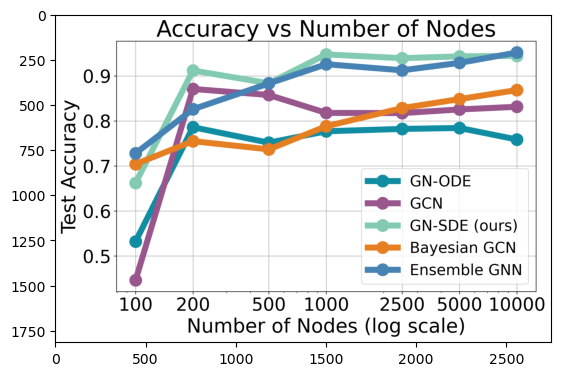

In [41]:
# Since the automated approach is not yielding the correct results, let's manually inspect the image to find the correct pixels.
# We will plot the image and use a tool to interactively select the color.

# Define a function to interactively get a color from the image when clicked.
def onclick(event):
    # Get the coordinates of the click
    ix, iy = int(event.xdata), int(event.ydata)
    # Get the RGB color at the clicked coordinates
    color = img.getpixel((ix, iy))
    # Print the color and coordinates
    print(f"Coordinates: ({ix}, {iy}), Color: {color}")

# Plot the image
fig, ax = plt.subplots()
ax.imshow(img)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()  # This will show the image and wait for a click to get the color.

# After running this cell, click on the legend next to "Ensemble GNN" to get the color.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

window_size = 2

# Extract noise levels and accuracies from the results dictionary
noise_levels = [key for key in results_ode.keys()]
accuracies_ode = [results_ode[key]['accuracy'] for key in results_ode.keys()]
accuracies_gcn = [results_gcn[key]['accuracy'] for key in results_gcn.keys()]
accuracies_sde = [results_sde[key]['accuracy'] for key in results_sde.keys()]

ode_accuracies_moving_avg = moving_average(accuracies_ode, window_size)
gcn_accuracies_moving_avg = moving_average(accuracies_gcn, window_size)
sde_accuracies_moving_avg = moving_average(accuracies_sde, window_size)

# Create the plot
plt.figure(figsize=(10, 6))
colors = {'sde': '#82cbb2', 'gnn': '#98568d', 'ode': '#108da3'}
plt.plot(noise_levels[window_size-1:], ode_accuracies_moving_avg, label='Graph Neural ODE', linewidth=8, color=colors['ode'])
plt.plot(noise_levels[window_size-1:], gcn_accuracies_moving_avg, label='GCN', linewidth=8, color=colors['gnn'])
plt.plot(noise_levels[window_size-1:], sde_accuracies_moving_avg, label='Graph Neural SDE', linewidth=8, color=colors['sde'])

plt.title('Noise vs Accuracy', fontsize=30)
plt.xlabel('Gaussian Noise Variance', fontsize=26)
plt.ylabel('Accuracy', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=26)  # Adjust the fontsize as needed

plt.legend(fontsize=20)
plt.grid(True)
plt.savefig('figures/noise_vs_acc.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


: 

In [ ]:
data_copy.x[data.test_mask]

: 

: 

## Active Learning

: 

In [186]:
def train_and_evaluate(model, data, learning_rate=0.01, weight_decay=5e-4, num_epochs=100):
    # Create an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    
    # Calculate train accuracy
    model.eval()
    _, train_pred = model(data).max(dim=1)
    correct_train = train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
    acc_train = correct_train / data.train_mask.sum().item()
    print('Train Accuracy: {:.4f}'.format(acc_train))

    # Calculate test accuracy
    _, pred = model(data).max(dim=1)
    correct_test = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc_test = correct_test / data.test_mask.sum().item()
    print('Test Accuracy: {:.4f}'.format(acc_test))
    
    # Return the trained model for future use
    return model


neural_ode = train_and_evaluate(neural_ode, data)

/scratch/rsb63/miniconda3/envs/gn-sde/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Accuracy: 0.7188
Test Accuracy: 1.0000


In [ ]:
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.00):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val

def kl_train_and_evaluate(model, data, learning_rate=0.01, weight_decay=5e-4, num_epochs=100):
    # Create an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    kl_scheduler = LinearScheduler(iters=50)
    model.train()
    for epoch in range(num_epochs):
        # print('epoch', epoch)
        optimizer.zero_grad()
        out, kl_div = model(data)
        ce_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        total_loss = ce_loss + kl_div*kl_scheduler.val
        total_loss.backward()
        optimizer.step()

    # Calculate train accuracy
    model.eval()
    train_out, _ = model(data)
    _, train_pred = train_out.max(dim=1)
    correct_train = train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
    acc_train = correct_train / data.train_mask.sum().item()
    print('Train Accuracy: {:.4f}'.format(acc_train))

    # Calculate test accuracy
    test_out, _ = model(data)
    _, pred = test_out.max(dim=1)
    correct_test = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc_test = correct_test / data.test_mask.sum().item()
    print('Test Accuracy: {:.4f}'.format(acc_test))
    
    # Return the trained model for future use
    return model

# model_BayesianSDE = LatentSDE(drift_net=gnn_f, in_net=gcn_in, out_net=gcn_out).to(device)
# trained_model_BayesianSDE = kl_train_and_evaluate(model_BayesianSDE, data)

: 

In [ ]:


class MyGCN2(torch.nn.Module):
    def __init__(self, edge_index, in_feats=num_feats, out_feats=num_classes, activation=None, dropout=0):
        super(MyGCN2, self).__init__()
        self.edge_index = edge_index
        self.dropout = dropout
        self.activation = activation
        self.conv1 = GCNConv(in_feats, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 16)
        self.conv4 = GCNConv(16, out_feats)

    def forward(self, data):
        x = data.x
        x = self.conv1(x, self.edge_index)
        if self.activation is not None:
            x = self.activation(x)
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, self.edge_index)
        x = self.activation(x)
        x = self.conv3(x, self.edge_index)
        x = self.activation(x)
        x = self.conv4(x, self.edge_index)
        x = self.activation(x)
        return F.softmax(x, dim=1)

gcn_model = MyGCN2(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softmax, dropout=0.0).to(device)
trained_model = train_and_evaluate(gcn_model, data)

: 

In [ ]:
# model = NeuralSDE(sde_func=gnn_f, in_net=gcn_in, out_net=gcn_out).to(device)
# trained_model = train_and_evaluate(model, data)

: 

In [ ]:


import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import entr
from matplotlib.lines import Line2D

def mean_samples(model, data, n_samples=1, is_bayesian=False):
    samples = []
    for s in range(n_samples):
        if is_bayesian:
            out, _ = model(data)
            sample = out.data.cpu().numpy()
        else:    
            sample = model(data).data.cpu().numpy()
        
        samples.append(sample)

    samples = np.array(samples)
    mean = np.mean(samples, axis=0)
    var = np.var(samples, axis=0).sum(axis=1)
    return var, mean

def accuracy(pred, actual):
    correct = float(pred.eq(actual).sum().item())
    total = actual.size(0)
    return correct / total

def accuracy(pred, actual, entropy, threshold):
    mask = entropy <= threshold
    pred = pred[mask].to('cpu')
    actual = actual[mask].to('cpu')
    correct = float(pred.eq(actual).sum().item())
    total = actual.size(0)
    if total > 0:
        acc = correct / total
    else:
        acc = None  # to avoid division by zero
    return acc, total

def plot_graph(G, model, data, title="Graph Plot", save_as=None, correctness_coloring=True, n_samples=1, is_bayesian=False):
    if correctness_coloring:
        colors = {True: 'y', False: 'r'}  # Green for correct, Red for incorrect
    else:
        colors = {0: 'r', 1: 'b', 2: 'g'}  # adjust as necessary for number of classes

    model.eval()
    if is_bayesian:
        out, _ = model(data)
        _, pred = out.max(dim=1)
    else:   
        _, pred = model(data).max(dim=1)
        
    # print("Train Accuracy: ", accuracy(pred[data.train_mask], data.y[data.train_mask]))
    # print("Test Accuracy: ", accuracy(pred[data.test_mask], data.y[data.test_mask]))
    pred = pred.to('cpu')  # Moving to CPU
    var, probs = mean_samples(model, data, n_samples, is_bayesian)  # get probabilities
    entropy = entr(probs).sum(axis=1)  # calculate entropy
    print('entropy', max(entropy))
    for threshold in [1.58, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
        test_acc, num_samples = accuracy(pred[data.test_mask.to('cpu')], data.y[data.test_mask.to('cpu') ], entropy[data.test_mask.to('cpu') ], threshold)
        if test_acc is not None:
             print(f"Test Accuracy (Entropy <= {threshold}): {test_acc} with {num_samples} test samples used")
            
             entropy = entr(probs).sum(axis=1)  # calculate entropy
            
    node_sizes = [(e*2)*1000 + 100 for e in entropy]  # scale entropy for visualization
    pos = nx.spring_layout(G, seed=42, k=0.5)
    if correctness_coloring:
        correctness = (pred.cpu().numpy() == data.y.cpu().numpy())
        node_colors = [colors[correct] for correct in correctness]
    else:
        classes = pred.cpu().numpy()
        node_colors = [colors[classes[i]] for i in range(num_nodes)]

    train_nodes = [node for node in G.nodes if data.train_mask[node]]
    test_nodes = [node for node in G.nodes if data.test_mask[node]]
    train_sizes = [node_sizes[i] for i in train_nodes]
    test_sizes = [node_sizes[i] for i in test_nodes]
    train_colors = [node_colors[i] for i in train_nodes]
    test_colors = [node_colors[i] for i in test_nodes]

    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos=pos, nodelist=test_nodes, node_color=test_colors, node_size=test_sizes, ax=ax)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=train_nodes, node_color=train_colors, node_size=train_sizes, edgecolors='black', linewidths=2, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, ax=ax)

    if correctness_coloring:
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='black', markersize=10, markeredgewidth=2, label='Train nodes'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[True], markersize=10, label='Correct Prediction'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[False], markersize=10, label='Incorrect Prediction'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=15, label='High Entropy'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='Low Entropy')]
    else:
        mispredicted_nodes = [node for node in test_nodes if pred[node] != data.y[node]]
        mispredicted_colors = [colors[data.y[node].item()] for node in mispredicted_nodes]
        mispredicted_sizes = [node_sizes[i] for i in mispredicted_nodes]
        mispredicted_colors_in_test = [test_colors[test_nodes.index(node)] for node in mispredicted_nodes]
        nx.draw_networkx_nodes(G, pos=pos, nodelist=mispredicted_nodes, node_color=mispredicted_colors_in_test, node_size=mispredicted_sizes, edgecolors=mispredicted_colors, linewidths=2, ax=ax)
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Class 0'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Class 1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Class 2'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=15, label='High Entropy'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='Low Entropy')]

    # ax.legend(handles=legend_elements, loc='best')
    plt.title(title)  # set title

    if save_as is not None:  # save the image if 'save_as' is provided
        plt.savefig(save_as)
    plt.show()


: 

In [ ]:
gcn_in = MyGCN(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=nn.Softplus(), dropout=0.0).to(device) 

gdefunc = nn.Sequential(MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=nn.Softplus(), dropout=0.0),
                  MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=None, dropout=0.0)
                 ).to(device)

# Complete gcn_out
gcn_out = MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=num_classes, activation=F.softmax, dropout=0.).to(device)

neural_ode = NeuralODE(in_net=gcn_in, ode_func=gdefunc, out_net=gcn_out).to(device)


neural_ode = train_and_evaluate(neural_ode, data)

plot_graph(G, neural_ode, data, title="GNODE", save_as="myoutputs/GNODE", correctness_coloring=True, n_samples=50, is_bayesian=False)
plot_graph(G, neural_ode, data, title="GNODE", save_as=None, correctness_coloring=False, n_samples=50, is_bayesian=False)

: 

In [ ]:

num_feats = features.shape[1]
gcn_in = MyGCN(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softplus, dropout=0.0).to(device) 

gnn_f = nn.Sequential(
    MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=F.softplus, dropout=0.0),
    MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=None, dropout=0.0)
).to(device)

# Complete gcn_out
gcn_out = nn.Sequential(
  MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=num_classes, activation=F.softmax, dropout=0.).to(device)
).to(device)

model_BayesianSDE = LatentSDE(drift_net=gnn_f, in_net=gcn_in, out_net=gcn_out).to(device)
trained_model_BayesianSDE = kl_train_and_evaluate(model_BayesianSDE, data)

plot_graph(G, trained_model_BayesianSDE, data, title="BGNSDE", save_as=None, correctness_coloring=True, n_samples=50, is_bayesian=True)
plot_graph(G, trained_model_BayesianSDE, data, title="BGNSDE", save_as=None, correctness_coloring=False, n_samples=50, is_bayesian=True)

: 

In [ ]:
# num_feats = features.shape[1]
# gcn_in = MyGCN(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softplus, dropout=0.0).to(device) 

# gnn_f = nn.Sequential(
#     MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=F.softplus, dropout=0.0),
#     MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=None, dropout=0.0)
# ).to(device)

# # Complete gcn_out
# gcn_out = nn.Sequential(
#   MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=num_classes, activation=F.softmax, dropout=0.).to(device)
# ).to(device)

# nueral_sde_model = NeuralSDE(sde_func=gnn_f, in_net=gcn_in, out_net=gcn_out).to(device)
# nueral_sde_model = train_and_evaluate(nueral_sde_model, data)


# plot_graph(G, nueral_sde_model, data, title="GNSDE", save_as=None, correctness_coloring=True, n_samples=50)
# plot_graph(G, nueral_sde_model, data, title="GNSDE", save_as=None, correctness_coloring=False, n_samples=50)

: 

In [ ]:
gcn_model = MyGCN2(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softplus, dropout=0.0).to(device)
gcn_model = train_and_evaluate(gcn_model, data)

gcn_model = MyGCN2(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softplus, dropout=0.0).to(device)
plot_graph(G, gcn_model, data, title="GNN", save_as=None, correctness_coloring=True, n_samples=50)
plot_graph(G, gcn_model, data, title="GNN", save_as=None, correctness_coloring=False)

: 

: 

In [ ]:
print(sum(data.train_mask)/(sum(data.train_mask) + sum(data.test_mask)))

: 

In [ ]:


import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import entr
from matplotlib.lines import Line2D

def mean_samples(model, data, n_samples=1, is_bayesian=False):
    samples = []
    for s in range(n_samples):
        if is_bayesian:
            out, _ = model(data)
            sample = out.data.cpu().numpy()
        else:    
            sample = model(data).data.cpu().numpy()
        
        samples.append(sample)

    samples = np.array(samples)
    mean = np.mean(samples, axis=0)
    var = np.var(samples, axis=0).sum(axis=1)
    return var, mean

def accuracy(pred, actual):
    correct = float(pred.eq(actual).sum().item())
    total = actual.size(0)
    return correct / total

def accuracy(pred, actual, entropy, threshold):
    mask = entropy <= threshold
    pred = pred[mask].to('cpu')
    actual = actual[mask].to('cpu')
    correct = float(pred.eq(actual).sum().item())
    total = actual.size(0)
    if total > 0:
        acc = correct / total
    else:
        acc = None  # to avoid division by zero
    return acc, total

def active_learning(G, model, data, title="Graph Plot", save_as=None, correctness_coloring=True, n_samples=1, is_bayesian=False):
    if correctness_coloring:
        colors = {True: 'y', False: 'r'}  # Green for correct, Red for incorrect
    else:
        colors = {0: 'r', 1: 'b', 2: 'g'}  # adjust as necessary for number of classes

    train_percentage = sum(data.train_mask)/(sum(data.train_mask) + sum(data.test_mask))
    num_epochs = 100
    while train_percentage < 0.8:
        # gnn_f = nn.Sequential(
        # MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=F.softplus, dropout=0.0),
        # MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=None, dropout=0.0)
        # ).to(device)

        # # Complete gcn_out
        # gcn_out = nn.Sequential(
        # MyGCN(edge_index=data.edge_index, in_feats=n_dimmention, out_feats=num_classes, activation=F.softmax, dropout=0.).to(device)
        # ).to(device)

        # model = LatentSDE(drift_net=gnn_f, in_net=gcn_in, out_net=gcn_out).to(device)
        # model = MyGCN2(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softplus, dropout=0.0).to(device)

        print('train percentage', float(train_percentage))
        #train model 
        if is_bayesian is False:
            model = train_and_evaluate(model, data, num_epochs=num_epochs)

        elif is_bayesian is True:
            model = kl_train_and_evaluate(model, data, num_epochs=num_epochs)
        
        #eval model 
        model.eval()
        if is_bayesian:
            out, _ = model(data)
            _, pred = out.max(dim=1)
        else:   
            _, pred = model(data).max(dim=1)
        
        #Select max entropy feature from the test dataset
        pred = pred.to('cpu')  # Moving to CPU
        var, probs = mean_samples(model, data, n_samples, is_bayesian)  # get probabilities
        # Convert probabilities to PyTorch tensor and move to the same device as your model
        probs = torch.tensor(probs).to(device)

        # # Calculate entropy
        # entropy = -torch.sum(probs * torch.log(probs), dim=1)
        # entropy = torch.where(data.train_mask, torch.zeros_like(entropy), entropy)
        # most_uncertain_node_test = torch.argmax(entropy)
        
        test_indices = torch.where(data.test_mask == True)[0]
        random_node_test = test_indices[torch.randint(len(test_indices), (1,))]

        # add the index of this node to the training mask and remove it from the test mask
        # data.train_mask[most_uncertain_node_test] = True
        # data.test_mask[most_uncertain_node_test] = False
        data.train_mask[random_node_test] = True
        data.test_mask[random_node_test] = False
        # update train_percentage for the while loop condition
        train_percentage = sum(data.train_mask)/(sum(data.train_mask) + sum(data.test_mask))
        num_epochs = 5
        

    
    model.eval()
    if is_bayesian:
        out, _ = model(data)
        _, pred = out.max(dim=1)
    else:   
        _, pred = model(data).max(dim=1)
        
    # print("Train Accuracy: ", accuracy(pred[data.train_mask], data.y[data.train_mask]))
    # print("Test Accuracy: ", accuracy(pred[data.test_mask], data.y[data.test_mask]))
    pred = pred.to('cpu')  # Moving to CPU
    var, probs = mean_samples(model, data, n_samples, is_bayesian)  # get probabilities
    entropy = entr(probs).sum(axis=1)  # calculate entropy
    print('entropy', max(entropy))
    for threshold in [1.58, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
        test_acc, num_samples = accuracy(pred[data.test_mask.to('cpu')], data.y[data.test_mask.to('cpu') ], entropy[data.test_mask.to('cpu') ], threshold)
        if test_acc is not None:
             print(f"Test Accuracy (Entropy <= {threshold}): {test_acc} with {num_samples} test samples used")
            
             entropy = entr(probs).sum(axis=1)  # calculate entropy
            
    node_sizes = [(e*2)*1000 + 100 for e in entropy]  # scale entropy for visualization
    pos = nx.spring_layout(G, seed=42, k=0.5)
    if correctness_coloring:
        correctness = (pred.cpu().numpy() == data.y.cpu().numpy())
        node_colors = [colors[correct] for correct in correctness]
    else:
        classes = pred.cpu().numpy()
        node_colors = [colors[classes[i]] for i in range(num_nodes)]

    train_nodes = [node for node in G.nodes if data.train_mask[node]]
    test_nodes = [node for node in G.nodes if data.test_mask[node]]
    train_sizes = [node_sizes[i] for i in train_nodes]
    test_sizes = [node_sizes[i] for i in test_nodes]
    train_colors = [node_colors[i] for i in train_nodes]
    test_colors = [node_colors[i] for i in test_nodes]

    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos=pos, nodelist=test_nodes, node_color=test_colors, node_size=test_sizes, ax=ax)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=train_nodes, node_color=train_colors, node_size=train_sizes, edgecolors='black', linewidths=2, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, ax=ax)

    if correctness_coloring:
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='black', markersize=10, markeredgewidth=2, label='Train nodes'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[True], markersize=10, label='Correct Prediction'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[False], markersize=10, label='Incorrect Prediction'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=15, label='High Entropy'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='Low Entropy')]
    else:
        mispredicted_nodes = [node for node in test_nodes if pred[node] != data.y[node]]
        mispredicted_colors = [colors[data.y[node].item()] for node in mispredicted_nodes]
        mispredicted_sizes = [node_sizes[i] for i in mispredicted_nodes]
        mispredicted_colors_in_test = [test_colors[test_nodes.index(node)] for node in mispredicted_nodes]
        nx.draw_networkx_nodes(G, pos=pos, nodelist=mispredicted_nodes, node_color=mispredicted_colors_in_test, node_size=mispredicted_sizes, edgecolors=mispredicted_colors, linewidths=2, ax=ax)
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Class 0'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Class 1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Class 2'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=15, label='High Entropy'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='Low Entropy')]

    # ax.legend(handles=legend_elements, loc='best')
    plt.title(title)  # set title

    if save_as is not None:  # save the image if 'save_as' is provided
        plt.savefig(save_as)
    plt.show()


: 

In [ ]:
from torch_geometric.data import Data
data_copy = Data()
for key, item in data:
    data_copy[key] = item.clone()
gcn_model = MyGCN2(edge_index=data_copy.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softplus, dropout=0.0).to(device)
active_learning(G, gcn_model, data_copy, title="GNN", save_as=None, correctness_coloring=True, n_samples=50)

: 

In [ ]:
data_copy = Data()
for key, item in data:
    data_copy[key] = item.clone()
    
num_feats = features.shape[1]
gcn_in = MyGCN(edge_index=data_copy.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.relu, dropout=0.0).to(device) 

gnn_f = nn.Sequential(
    MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=F.softplus, dropout=0.0),
    MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=None, dropout=0.0)
).to(device)

# Complete gcn_out
gcn_out = nn.Sequential(
  MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=num_classes, activation=F.softmax, dropout=0.).to(device)
).to(device)

model_latentSDE = LatentSDE(drift_net=gnn_f, in_net=gcn_in, out_net=gcn_out).to(device)

active_learning(G, model_latentSDE, data_copy, title="BGNSDE", save_as=None, correctness_coloring=True, n_samples=50, is_bayesian=True)

: 

In [ ]:
data_copy = Data()
for key, item in data:
    data_copy[key] = item.clone()
    
gcn_in = MyGCN(edge_index=data_copy.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=nn.Softplus(), dropout=0.0).to(device) 

gdefunc = nn.Sequential(MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=nn.Softplus(), dropout=0.0),
                  MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=None, dropout=0.0)
                 ).to(device)

# Complete gcn_out
gcn_out = MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=num_classes, activation=F.softmax, dropout=0.).to(device)

neural_ode = NeuralODE(in_net=gcn_in, ode_func=gdefunc, out_net=gcn_out).to(device)

active_learning(G, neural_ode, data_copy, title="GNODE", save_as="myoutputs/GNODE", correctness_coloring=True, n_samples=50, is_bayesian=False)

: 

: 

: 

: 

In [ ]:
from torch_geometric.data import Data
data_copy = Data()
for key, item in data:
    data_copy[key] = item.clone()
gcn_model = MyGCN2(edge_index=data_copy.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softplus, dropout=0.0).to(device)
active_learning(G, gcn_model, data_copy, title="GNN", save_as=None, correctness_coloring=True, n_samples=50)

: 

In [ ]:
data_copy = Data()
for key, item in data:
    data_copy[key] = item.clone()
    
num_feats = features.shape[1]
gcn_in = MyGCN(edge_index=data_copy.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.relu, dropout=0.0).to(device) 

gnn_f = nn.Sequential(
    MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=F.softplus, dropout=0.0),
    MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=None, dropout=0.0)
).to(device)

# Complete gcn_out
gcn_out = nn.Sequential(
  MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=num_classes, activation=F.softmax, dropout=0.).to(device)
).to(device)

model_latentSDE = LatentSDE(drift_net=gnn_f, in_net=gcn_in, out_net=gcn_out).to(device)

active_learning(G, model_latentSDE, data_copy, title="BGNSDE", save_as=None, correctness_coloring=True, n_samples=50, is_bayesian=True)

: 

In [ ]:
data_copy = Data()
for key, item in data:
    data_copy[key] = item.clone()
    
gcn_in = MyGCN(edge_index=data_copy.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=nn.Softplus(), dropout=0.0).to(device) 

gdefunc = nn.Sequential(MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=nn.Softplus(), dropout=0.0),
                  MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=n_dimmention, activation=None, dropout=0.0)
                 ).to(device)

# Complete gcn_out
gcn_out = MyGCN(edge_index=data_copy.edge_index, in_feats=n_dimmention, out_feats=num_classes, activation=F.softmax, dropout=0.).to(device)

neural_ode = NeuralODE(in_net=gcn_in, ode_func=gdefunc, out_net=gcn_out).to(device)

active_learning(G, neural_ode, data_copy, title="GNODE", save_as="myoutputs/GNODE", correctness_coloring=True, n_samples=50, is_bayesian=False)

: 

: 

: 

: 

: 

: 

In [ ]:
import fire
import matplotlib.pyplot as plt
import torch
import torch.optim.swa_utils as swa_utils
import torchcde
import torchsde

import tqdm
import numpy.random as npr
import numpy as np
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from collections import namedtuple
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])


###################
# First some standard helper objects.
###################

class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x) # silu(x)=x∗σ(x), where σ(x) is the logistic sigmoid.


class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size),
                 LipSwish()]
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            ###################
            # LipSwish activations are useful to constrain the Lipschitz constant of the discriminator.
            # (For simplicity we additionally use them in the generator, but that's less important.)
            ###################
            model.append(LipSwish())
        model.append(torch.nn.Linear(mlp_size, out_size))
        if tanh:
            model.append(torch.nn.Tanh())
        self._model = torch.nn.Sequential(*model).to(device)

    def forward(self, x):
        return self._model(x.to(device))
    



class MyGCN(torch.nn.Module):
    def __init__(self, edge_index, in_feats, out_feats, activation=None, dropout=0):
        super(MyGCN, self).__init__()
        self.edge_index = edge_index
        self.dropout = dropout
        self.activation = activation
        self.conv1 = GCNConv(in_feats, out_feats)

    def forward(self, x):
        x = self.conv1(x, self.edge_index)
        if self.activation is not None:
            x = self.activation(x)
        x = F.dropout(x, p=self.dropout)
        return x
    

###################
# Now we define the SDEs.
# MyGCN2(edge_index=data.edge_index, in_feats=num_feats, out_feats=n_dimmention, activation=F.softplus, dropout=0.0).to(device)
# We begin by defining the generator SDE.
###################
class GeneratorFunc(torch.nn.Module):
    sde_type = 'stratonovich'
    noise_type = 'general'

    def __init__(self, edge_index, in_size, hidden_size, noise_size, activation=F.softplus):
        super().__init__()
        self._noise_size = noise_size
        self._hidden_size = hidden_size

        ###################
        # Drift and diffusion are MLPs. They happen to be the same size.
        # Note the final tanh nonlinearity: this is typically important for good performance, to constrain the rate of
        # change of the hidden state.
        # If you have problems with very high drift/diffusions then consider scaling these so that they squash to e.g.
        # [-3, 3] rather than [-1, 1].
        ###################
        
        self._drift = nn.Sequential(
            MyGCN(edge_index=edge_index, in_feats=in_size, out_feats=hidden_size, activation=F.softplus, dropout=0.0),
            MyGCN(edge_index=edge_index, in_feats=hidden_size, out_feats=hidden_size, activation=None, dropout=0.0)
        ).to(device)

        self._diffusion = MyGCN(edge_index, hidden_size, hidden_size * noise_size, activation)

    def f_and_g(self, t, x):

        return self._drift(x), self._diffusion(x).view(x.size(0), self._hidden_size, self._noise_size)


###################
# Now we wrap it up into something that computes the SDE.
###################
class Generator(torch.nn.Module):
    def __init__(self, edge_index, data_size, initial_noise_size, noise_size, hidden_size):
        super().__init__()
        self._initial_noise_size = initial_noise_size
        self._hidden_size = hidden_size

        self._initial = MyGCN(edge_index, initial_noise_size, hidden_size, activation=F.softplus, dropout=0.0)
        self._func = GeneratorFunc(edge_index, in_size=hidden_size, hidden_size=hidden_size, noise_size=noise_size)
        self._readout = MyGCN(edge_index, hidden_size, data_size, activation=F.softplus, dropout=0.0)

    def forward(self, ts=torch.tensor([0, 1.]).float().to(device)):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.
        ###################
        # Actually solve the SDE.
        ###################
        batch_size=200 # Make this more robust (same number as datapoints)
        init_noise = torch.randn(batch_size, self._initial_noise_size, device=ts.device)
        x0 = self._initial(init_noise)

        ###################
        # We use the reversible Heun method to get accurate gradients whilst using the adjoint method.
        ###################
        print('1'*100)
        xs = torchsde.sdeint(self._func, x0, ts, method='midpoint', dt=0.1)
        print('2'*100)
        xs = xs.transpose(0, 1)
        print('3'*100)
        ys = xs
        print('4'*100)
        ###################
        # Normalise the data to the form that the discriminator expects, in particular including time as a channel.
        ###################

        # ts = ts.unsqueeze(0).unsqueeze(-1).expand(batch_size, ts.size(0), 1)
        
        return ys # Not sure if I need to return more features x, y and t?

# torch.cat((torch.sin(t), torch.cos(t), y), dim=-1)

###################
# Next the discriminator. Here, we're going to use a neural controlled differential equation (neural CDE) as the
# discriminator, just as in the "Neural SDEs as Infinite-Dimensional GANs" paper. (You could use other things as well,
# but this is a natural choice.)
#
# There's actually a few different (roughly equivalent) ways of making the discriminator work. The curious reader is
# encouraged to have a read of the comment at the bottom of this file for an in-depth explanation.
###################
class DiscriminatorFunc(torch.nn.Module):
    def __init__(self, edge_index, data_size, hidden_size):
        super().__init__()
        self._data_size = data_size
        self._hidden_size = hidden_size

        # tanh is important for model performance dge_index, initial_noise_size, hidden_size, activation=F.softplus, dropout=0.0
        self._module = MyGCN(edge_index,  hidden_size, hidden_size * ( data_size), F.softplus,  dropout=0.0)

    def forward(self, t, h):
        # t has shape ()
        # h has shape (batch_size, hidden_size)
        return self._module(h).view(h.size(0), self._hidden_size, self._data_size)


class Discriminator(torch.nn.Module):
    def __init__(self, edge_index, data_size, hidden_size):
        super().__init__()

        self._initial = MyGCN(edge_index, data_size, hidden_size, F.softplus,  dropout=0.0)
        self._func = DiscriminatorFunc(edge_index, data_size, hidden_size)
        self._readout = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        # ys_coeffs has shape (batch_size, t_size, 1 + data_size)
        # The +1 corresponds to time. When solving CDEs, It turns out to be most natural to treat time as just another
        # channel: in particular this makes handling irregular data quite easy, when the times may be different between
        # different samples in the batch.
        ys_coeffs = x
        Y = torchcde.LinearInterpolation(ys_coeffs)
        print('Y', Y.interval)
        print('Y.interval[0]', Y.interval[0])
        Y0 = Y.evaluate(Y.interval[0])
        h0 = self._initial(Y0)
        hs = torchcde.cdeint(Y, self._func, h0, Y.interval, method='reversible_heun', backend='torchsde', dt=1.0,
                             adjoint_method='adjoint_reversible_heun',
                             adjoint_params=(ys_coeffs,) + tuple(self._func.parameters()))
        score = self._readout(hs[:, -1])
        return score.mean()

: 

In [ ]:
 # Models
generator = Generator(data.edge_index, data_size=2, initial_noise_size=2, noise_size=2, hidden_size=16).to(device)
discriminator = Discriminator(data.edge_index,data_size=16, hidden_size=16).to(device)
# Weight averaging really helps with GAN training.
averaged_generator = swa_utils.AveragedModel(generator)
averaged_discriminator = swa_utils.AveragedModel(discriminator)


# Picking a good initialisation is important!
# In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
# size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
# Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
# What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
# (e.g. pretraining the t=0 distribution)
# with torch.no_grad():
#     for param in generator._initial.parameters():
#         param *= init_mult1
#     for param in generator._func.parameters():
#         param *= init_mult2

# Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
# generator_optimiser = torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
# discriminator_optimiser = torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
#                                                weight_decay=weight_decay)

def evaluate_loss(device, generator, discriminator):
    
    real_samples = data.x.to(device), data.y.to(device)
    generated_samples = generator()
    generated_score = discriminator(generated_samples)        

    print('real_samples', real_samples)
    real_samples[0] = real_samples[0].view(-1, 1)  # reshape it to [40, 1]
    real_samples = torch.cat(real_samples, dim=1)  # resulting tensor will have shape [40, 2]
    real_samples = real_samples.unsqueeze(0)

    real_score = discriminator(real_samples)
    loss = generated_score + real_score
    
    return loss


# # Optimisers. We'll use Adam for both the generator and discriminator.
generator_optimiser = torch.optim.Adam(generator.parameters())
discriminator_optimiser = torch.optim.Adam(discriminator.parameters())

# Train both generator and discriminator.
steps=100
trange = tqdm.tqdm(range(steps))
for step in trange:
    
    # real_samples, generated_samples, generated_score = get_samples(device, generator, discriminator, batch_size, step)
    
    loss = evaluate_loss(device, generator, discriminator)
    loss.backward()

    for param in generator.parameters():
        param.grad *= -1
    generator_optimiser.step()
    
    discriminator_optimiser.step()
    generator_optimiser.zero_grad()
    discriminator_optimiser.zero_grad()

    # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
    # LipSwish activation functions).
    ###################
    with torch.no_grad():
        for module in discriminator.modules():
            if isinstance(module, torch.nn.Linear):
                lim = 1 / module.out_features
                module.weight.clamp_(-lim, lim)

    # Stochastic weight averaging typically improves performance.
    if step > 50:
        averaged_generator.update_parameters(generator)
        averaged_discriminator.update_parameters(discriminator)

    if (step % 10) == 0 or step == steps - 1:
        total_unaveraged_loss =  evaluate_loss(device, generator, discriminator)


generator.load_state_dict(averaged_generator.module.state_dict())
discriminator.load_state_dict(averaged_discriminator.module.state_dict())




: 

In [ ]:
data.x.shape

: 

: 

In [ ]:


import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import entr
from matplotlib.lines import Line2D

def mean_samples(model, data, n_samples=1, is_bayesian=False):
    samples = []
    for s in range(n_samples):
        if is_bayesian:
            out, _ = model(data)
            sample = out.data.cpu().numpy()
        else:    
            sample = model(data).data.cpu().numpy()
        
        samples.append(sample)

    samples = np.array(samples)
    mean = np.mean(samples, axis=0)
    var = np.var(samples, axis=0).sum(axis=1)
    return var, mean

def accuracy(pred, actual):
    correct = float(pred.eq(actual).sum().item())
    total = actual.size(0)
    return correct / total

def accuracy(pred, actual, entropy, threshold):
    mask = entropy <= threshold
    pred = pred[mask].to('cpu')
    actual = actual[mask].to('cpu')
    correct = float(pred.eq(actual).sum().item())
    total = actual.size(0)
    if total > 0:
        acc = correct / total
    else:
        acc = None  # to avoid division by zero
    return acc, total

def plot_graph(G, model, data, title="Graph Plot", save_as=None, correctness_coloring=True, n_samples=1, is_bayesian=False):
    if correctness_coloring:
        colors = {True: 'y', False: 'r'}  # Green for correct, Red for incorrect
    else:
        colors = {0: 'r', 1: 'b', 2: 'g'}  # adjust as necessary for number of classes

    model.eval()
    if is_bayesian:
        out, _ = model(data)
        _, pred = out.max(dim=1)
    else:   
        _, pred = model(data).max(dim=1)
        
    # print("Train Accuracy: ", accuracy(pred[data.train_mask], data.y[data.train_mask]))
    # print("Test Accuracy: ", accuracy(pred[data.test_mask], data.y[data.test_mask]))
    pred = pred.to('cpu')  # Moving to CPU
    var, probs = mean_samples(model, data, n_samples, is_bayesian)  # get probabilities
    entropy = entr(probs).sum(axis=1)  # calculate entropy
    print('entropy', max(entropy))
    for threshold in [1.58, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
        test_acc, num_samples = accuracy(pred[data.test_mask.to('cpu')], data.y[data.test_mask.to('cpu') ], entropy[data.test_mask.to('cpu') ], threshold)
        if test_acc is not None:
             print(f"Test Accuracy (Entropy <= {threshold}): {test_acc} with {num_samples} test samples used")
            
             entropy = entr(probs).sum(axis=1)  # calculate entropy
            
    node_sizes = [(e*2)*1000 + 100 for e in entropy]  # scale entropy for visualization
    pos = nx.spring_layout(G, seed=42, k=0.5)
    if correctness_coloring:
        correctness = (pred.cpu().numpy() == data.y.cpu().numpy())
        node_colors = [colors[correct] for correct in correctness]
    else:
        classes = pred.cpu().numpy()
        node_colors = [colors[classes[i]] for i in range(num_nodes)]

    train_nodes = [node for node in G.nodes if data.train_mask[node]]
    test_nodes = [node for node in G.nodes if data.test_mask[node]]
    train_sizes = [node_sizes[i] for i in train_nodes]
    test_sizes = [node_sizes[i] for i in test_nodes]
    train_colors = [node_colors[i] for i in train_nodes]
    test_colors = [node_colors[i] for i in test_nodes]

    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos=pos, nodelist=test_nodes, node_color=test_colors, node_size=test_sizes, ax=ax)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=train_nodes, node_color=train_colors, node_size=train_sizes, edgecolors='black', linewidths=2, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, ax=ax)

    if correctness_coloring:
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='black', markersize=10, markeredgewidth=2, label='Train nodes'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[True], markersize=10, label='Correct Prediction'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[False], markersize=10, label='Incorrect Prediction'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=15, label='High Entropy'),
                            Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='Low Entropy')]
    else:
        mispredicted_nodes = [node for node in test_nodes if pred[node] != data.y[node]]
        mispredicted_colors = [colors[data.y[node].item()] for node in mispredicted_nodes]
        mispredicted_sizes = [node_sizes[i] for i in mispredicted_nodes]
        mispredicted_colors_in_test = [test_colors[test_nodes.index(node)] for node in mispredicted_nodes]
        nx.draw_networkx_nodes(G, pos=pos, nodelist=mispredicted_nodes, node_color=mispredicted_colors_in_test, node_size=mispredicted_sizes, edgecolors=mispredicted_colors, linewidths=2, ax=ax)
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Class 0'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Class 1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Class 2'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=15, label='High Entropy'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='Low Entropy')]

    # ax.legend(handles=legend_elements, loc='best')
    plt.title(title)  # set title

    if save_as is not None:  # save the image if 'save_as' is provided
        plt.savefig(save_as)
    plt.show()


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 